## Imports and setting variables

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass, field
from typing import TYPE_CHECKING
import matplotlib.gridspec as gridspec
if TYPE_CHECKING:
    from numpy.typing import NDArray
    
from scipy.stats import pearsonr
import warnings

In [96]:
EME = np.loadtxt('DataSetCoursework_EME.txt')
ORA = np.loadtxt('DataSetCoursework_ORA.txt')

In [97]:
Spikes_EME = EME[:, :-2] # Column 1 to 6
ground_tr_EME = EME[:, -2] # Column 7
Trials_EME = EME[:, -1] # Column 8

Spikes_ORA = ORA[:, :-2] # Column 1 to 6
ground_tr_ORA = ORA[:, -2] # Column 7
Trials_ORA = ORA[:, -1] # Column 8

## Estimate firing rate

#### Calculate the firing rate:
$$r = \frac {n(spikes\space per\space trials)}{T (total\space trial\space duration)} $$

In [98]:
warnings.simplefilter('ignore')
@dataclass
class Fire_Rate_Estimation:
    spikes: 'NDArray'
    trials: 'NDArray'
    dataset_name: str
    bin_size: float = field(init=False, default=.01)

    def Calculate_rate(self, window_size):
        
        try:
            n, m = self.spikes.shape
        except ValueError as e:
            n = self.spikes.shape[0]
            m = 1
            
        window_steps = int(window_size / self.bin_size)
        Rate = np.zeros_like(self.spikes)
        
        # Iterate over neurons and calculate firing rates
        for j in range(m):
            Smothed = []
            for i in range(n - window_steps + 1):
                spike_one_neuron = self.spikes[i: i + window_steps, j]
                rate_in_this_window = (np.sum(spike_one_neuron) / window_size) # Calculating the firing rate in each time window
                Smothed.append(rate_in_this_window)
            Smothed.extend([Smothed[-1]] * (window_steps - 1))
            Rate[:, j] = Smothed
            
        Rate = np.hstack((Rate, self.trials[:, np.newaxis])) # Adding the trials column to the Rate matrix
        
        return Rate

    def display_aggregated_plot(self, rate):
        n_1, neurons = self.spikes.shape
        times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
        
        fig, axs = plt.subplots(neurons, 2, figsize=(15, 8))
        fig.suptitle(f"Firing rate from {self.dataset_name} dataset")
        for j in range(neurons):
            axs[j, 0].plot(times, self.spikes[:, j])
            axs[j, 0].set_title(f'Neuron {j + 1}')
            axs[j, 0].set_ylabel('Spikes')
            axs[j, 0].set_xlabel('Time (s)')

            axs[j, 1].plot(times, rate[:, j], 'r')
            axs[j, 1].set_title(f'Neuron {j + 1} rate')
            axs[j, 1].set_ylabel('Hz')
            axs[j, 1].set_xlabel('Time (s)')

        # plt.title("sdf")
        fig.tight_layout()
        plt.show()
        
    def display_trial_plot(self, rate, trial_num: int, selected_neuron: int):
        n_1, neurons = self.spikes.shape
        times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
        
        if trial_num + 1 > int(max(self.trials)) + 1:
            trial_num = int(max(self.trials)) + 1
        
        # for j in range(neurons):
        for i in range(1, trial_num + 1):
            trial_index = (self.trials == i)
            # print("analysis: ",len(times[:len(self.spikes[trial_index, j])]), len(self.spikes[trial_index, j]))
            fig, axs = plt.subplots(1, 2, figsize=(20, 2))
            fig.suptitle(f"Firing rate from {self.dataset_name} dataset")
            axs[0].plot(times[:len(self.spikes[trial_index, selected_neuron - 1])], self.spikes[trial_index, selected_neuron - 1])
            axs[0].set_title(f'Neuron {selected_neuron}, trial: {i}')
            axs[0].set_ylabel('Spikes')
            axs[0].set_xlabel('Time (s)')

            axs[1].plot(times[:len(self.spikes[trial_index, selected_neuron - 1])], rate[trial_index, selected_neuron - 1], 'r')
            axs[1].set_title(f'Neuron {selected_neuron} rate, trial: {i}')
            axs[1].set_ylabel('Hz')
            axs[1].set_xlabel('Time (s)')

        # plt.title("sdf")
        plt.tight_layout()
        plt.show()
        

    def Calculate_corrolation_coef(self, rate):
        print(f"Corrolation rate and p-Value from {self.dataset_name} Dataset")
        # Correlation coefficients between spike trains and rates
        # print('********************************')
        # print('CORRELATION COEFFICIENTS RATE vs SPIKES (p value). Significance: p<0.05')
        # print('********************************')
        _, neurons = self.spikes.shape
        
        all_trails_corr = []
        all_trails_p_value = []
        all_trails_neurons = []
        
        for j in range(neurons):
            for i in range(1, int(max(self.trials)) + 1):
                trial_index = (self.trials == i)
                current_trial_rates = rate[trial_index, j]
                current_trial_spikes = self.spikes[trial_index, j]
                corr_value, p = pearsonr(current_trial_rates, current_trial_spikes)
                # print(f'Trial {i} Neuron {j + 1} correlation = {corr_value} ({p})')
            current_rates = rate[:, j]
            current_spikes = self.spikes[:, j]
            corr_value, p = pearsonr(current_rates, current_spikes)
            
            all_trails_corr.append(corr_value)
            all_trails_p_value.append(p)
            all_trails_neurons.append(f"Neuron {j + 1}")
            # print('********************************')
            # print(f'All trials Neuron {j + 1} correlation = {corr_value} ({p})')
            # print('********************************')
        
        return pd.DataFrame({'Neuron': all_trails_neurons, 'Correlation Coefficient': all_trails_corr, 'P-Value': all_trails_p_value})

## Finding the optimal windows size

- Using two metrics to find the 

In [99]:
@dataclass
class Find_optimal_window:
    window_start: float
    window_stop: float|int
    ds: 'NDArray'
    ds_trials: 'NDArray'
    ds_name: str
    
    
    def _Calculate_rate(self, window_size, bin_size=.01):
        
        try:
            n, m = self.ds.shape
        except ValueError as e:
            n = self.ds.shape[0]
            m = 1
            
        window_steps = int(window_size / bin_size)
        Rate = np.zeros_like(self.ds)
        
        # Iterate over neurons and calculate firing rates
        for j in range(m):
            Smothed = []
            for i in range(n - window_steps + 1):
                spike_one_neuron = self.ds[i: i + window_steps, j]
                rate_in_this_window = (np.sum(spike_one_neuron) / window_size) # Calculating the firing rate in each time window
                Smothed.append(rate_in_this_window)
            Smothed.extend([Smothed[-1]] * (window_steps - 1))
            Rate[:, j] = Smothed
            
        Rate = np.hstack((Rate, self.ds_trials[:, np.newaxis])) # Adding the trials column to the Rate matrix
        
        return Rate
    
    def sliding_window(self, verbose=True):
        window_sizes = np.linspace(self.window_start, self.window_stop)
        _, num_neurons = self.ds.shape

        window_size_arr = []
        p_values = []
        r_squared_values = []

        # Loop through window sizes
        for win_size in window_sizes:
            current_rate = self._Calculate_rate(window_size=win_size)
            p_val_sum = 0
            r2_sum = 0
            
            # Evaluate all neurons
            for neuron in range(num_neurons):
                
                rate = current_rate[:, neuron]
                spikes = self.ds[:, neuron]
                
                # for i in range(1, int(max(self.ds_trials)) + 1):
                #     trial_index = (self.ds_trials == i)
                #     current_trial_rates = current_rate[trial_index, neuron]
                #     current_trial_spikes = self.ds[trial_index, neuron]
                #     corr_value, p = pearsonr(current_trial_rates, current_trial_spikes)
                
                # Compute correlation and p-value
                corr_coef, p_value = pearsonr(rate, spikes)
                p_val_sum += p_value
                
                # Compute R^2
                residuals = spikes - rate
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((spikes - np.mean(spikes))**2)
                r2 = 1 - (ss_res / ss_tot)
                r2_sum += r2
            
            # Average metrics across neurons
            avg_p_value = p_val_sum / num_neurons
            # avg_p_value = p_val_sum
            avg_r_squared = r2_sum / num_neurons
            
            window_size_arr.append(win_size)
            p_values.append(avg_p_value)
            r_squared_values.append(avg_r_squared)
            
        if verbose:
            # self.p_value_evolution(window_size_arr, p_values)
            # self.r_square_evolution(window_size_arr, r_squared_values)
            fig = plt.figure(figsize=(18, 10))
            gs = gridspec.GridSpec(1, 2)
            
            # P-value plot shwing the evolution of p-value across different windows sizes
            ax1 = fig.add_subplot(gs[0])
            ax1.plot(window_size_arr, p_values, label="P-values", marker='o')
            ax1.axhline(0.05, color='red', linestyle='--', label="P-value threshold (0.05)")
            ax1.set_title(f"Evolution of P-values {self.ds_name}")
            ax1.set_xlabel("Window Size (s)")
            ax1.set_ylabel("P-value")
            ax1.legend()
            ax1.grid()
            
            # R^2 plot showing the evolution of the R square value with different window sizes
            ax2 = fig.add_subplot(gs[1])
            ax2.plot(window_size_arr, r_squared_values, label="R^2 Values", marker='x')
            ax2.set_title(f"Evolution of R square with Window Size {self.ds_name}")
            ax2.set_xlabel("Window Size (s)")
            ax2.set_ylabel("R square Value")
            ax2.legend()
            ax2.grid()
        
    def sliding_window_trial(self, trial_num: int, verbose=True):
        window_sizes = np.linspace(self.window_start, self.window_stop)
        _, num_neurons = self.ds.shape

        window_size_arr = []
        p_values = []
        r_squared_values = []
        p_val_sum = 0
        r2_sum = 0
        
        
        for i in range(1, trial_num + 1):
            trial_index = (self.ds_trials == i)
            
            for win_size in window_sizes:
                current_rate = self._Calculate_rate(window_size=win_size)
                p_val_sum = 0
                r2_sum = 0
                
                for neuron in range(num_neurons):
                
                    current_trial_rates = current_rate[trial_index, neuron]
                    current_trial_spikes = self.ds[trial_index, neuron]
                    corr_value, p = pearsonr(current_trial_rates, current_trial_spikes)
                    p_val_sum += p
                
                avg_p_value = p_val_sum / num_neurons
                window_size_arr.append(win_size)
                p_values.append(avg_p_value)
                
            if verbose:
                # self.p_value_evolution(window_size_arr, p_values)
                # self.r_square_evolution(window_size_arr, r_squared_values)
                fig = plt.figure(figsize=(15, 4))
                gs = gridspec.GridSpec(1, 2)
                
                # P-value plot shwing the evolution of p-value across different windows sizes
                ax1 = fig.add_subplot(gs[0])
                ax1.plot(window_size_arr, p_values, label="P-values", marker='o')
                ax1.axhline(0.05, color='red', linestyle='--', label="P-value threshold (0.05)")
                ax1.set_title(f"P-values {self.ds_name}, Trial: {i}")
                ax1.set_xlabel("Window Size (s)")
                ax1.set_ylabel("P-value")
                ax1.legend()
                ax1.grid()
                
                # R^2 plot showing the evolution of the R square value with different window sizes
                # ax2 = fig.add_subplot(gs[1])
                # ax2.plot(window_size_arr, r_squared_values, label="R^2 Values", marker='x')
                # ax2.set_title(f"Evolution of R square with Window Size {self.ds_name}")
                # ax2.set_xlabel("Window Size (s)")
                # ax2.set_ylabel("R square Value")
                # ax2.legend()
                # ax2.grid()      

In [100]:
Optimal_win_size_EME = Find_optimal_window(ds=Spikes_EME, ds_trials=Trials_EME,window_start=.01, window_stop=1, ds_name="EME (Real)")
Optimal_win_size_ORA = Find_optimal_window(ds=Spikes_ORA, ds_trials=Trials_ORA, window_start=.01, window_stop=1, ds_name="ORA (Real)")

##### Trial by trial analysis

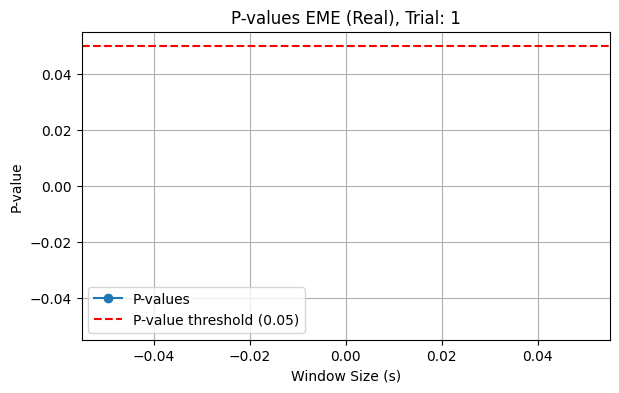

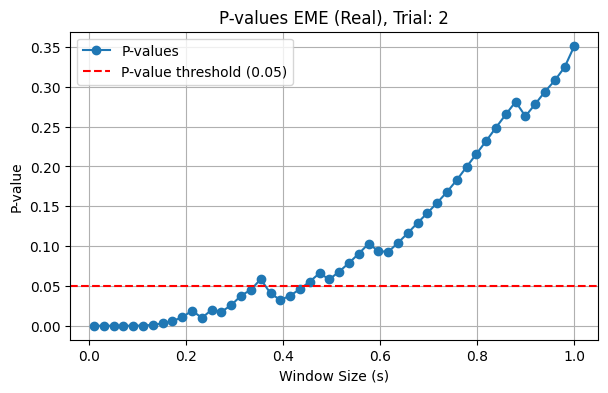

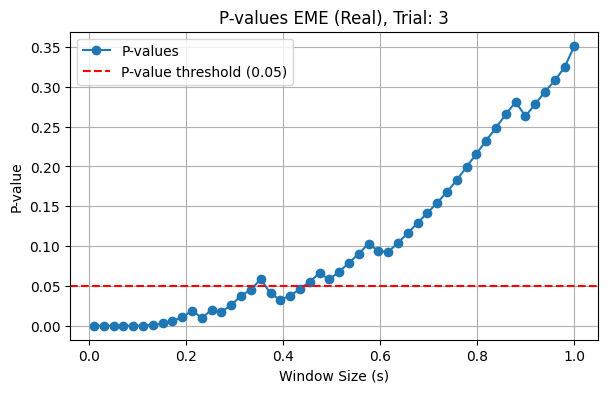

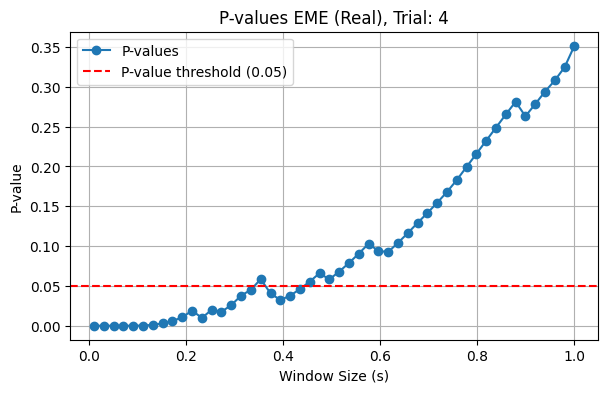

In [101]:
Optimal_win_size_EME.sliding_window_trial(trial_num=4)

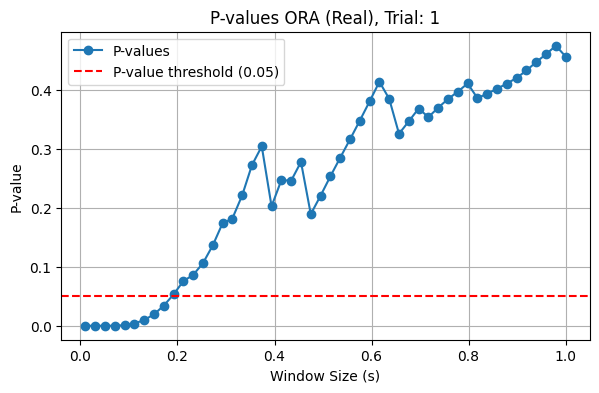

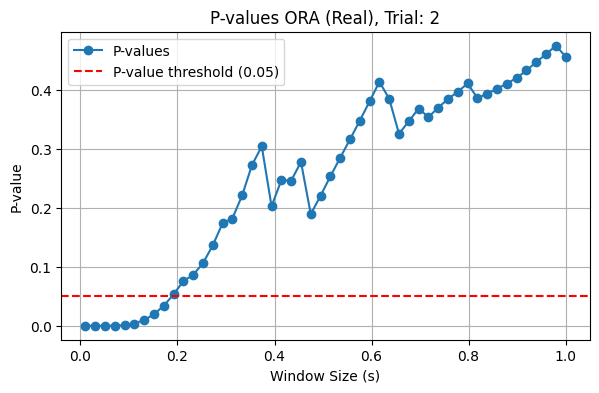

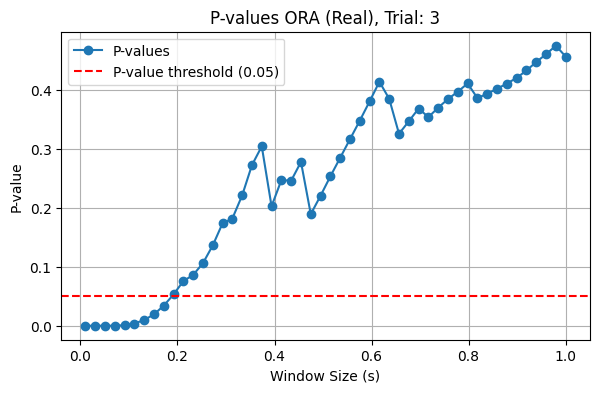

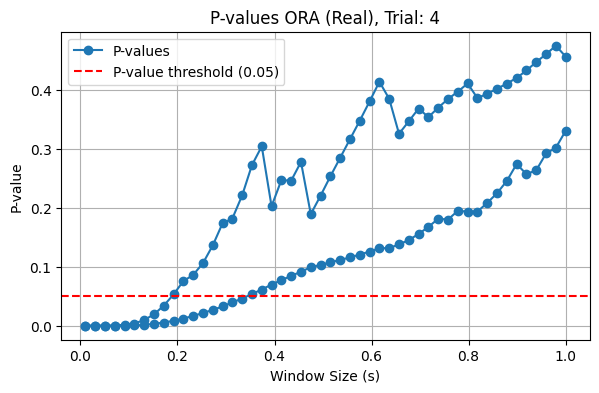

In [102]:
Optimal_win_size_ORA.sliding_window_trial(trial_num=4)

## Display neurons rate and correlations

In [103]:
Firing_Rate_EME = Fire_Rate_Estimation(spikes=Spikes_EME, trials=Trials_EME, dataset_name="EME (Real)")
Firing_Rate_ORA = Fire_Rate_Estimation(spikes=Spikes_ORA, trials=Trials_ORA, dataset_name="ORA (Real)")

In [104]:
rate_EME = Firing_Rate_EME.Calculate_rate(window_size=.2)
rate_ORA = Firing_Rate_ORA.Calculate_rate(window_size=.18)

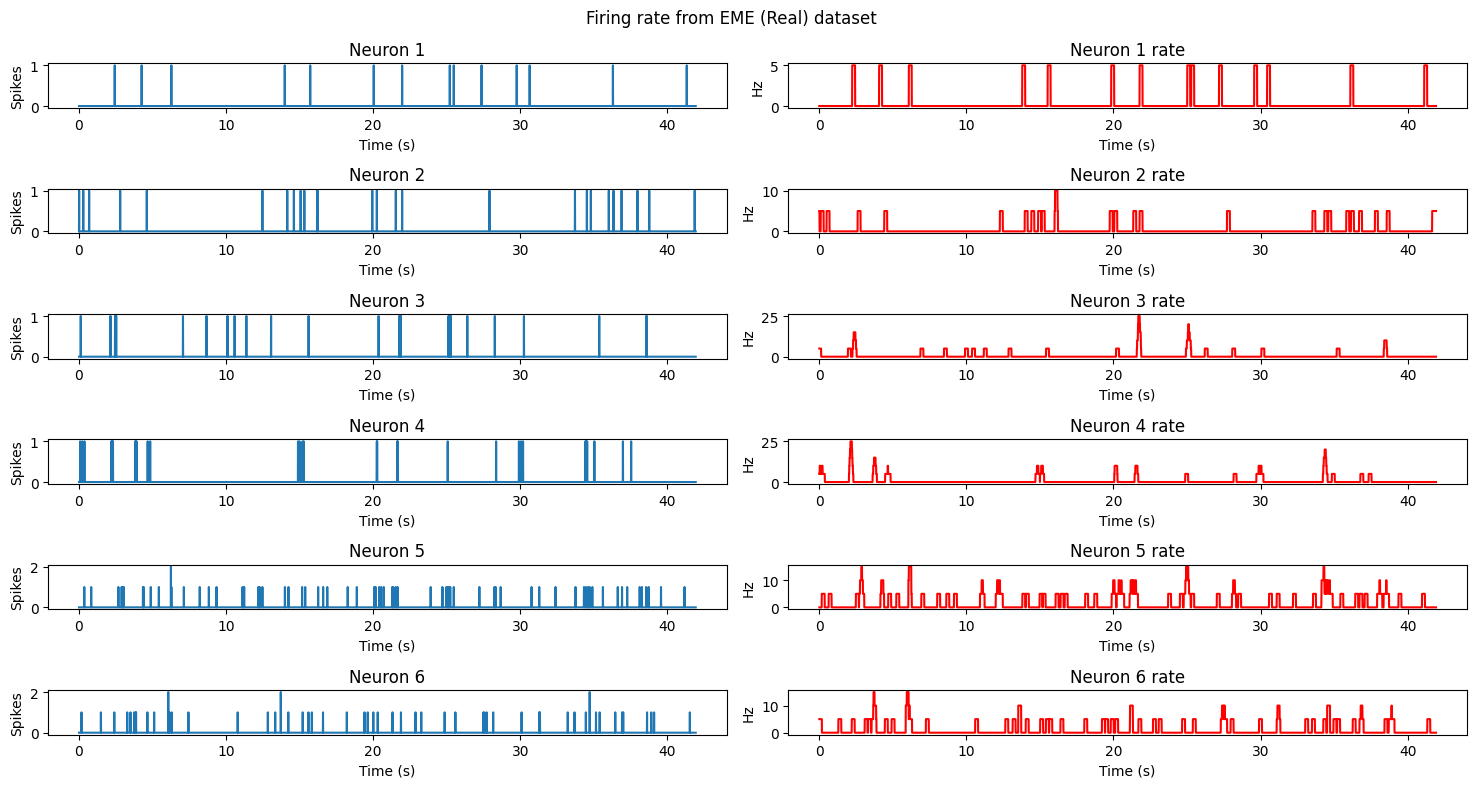

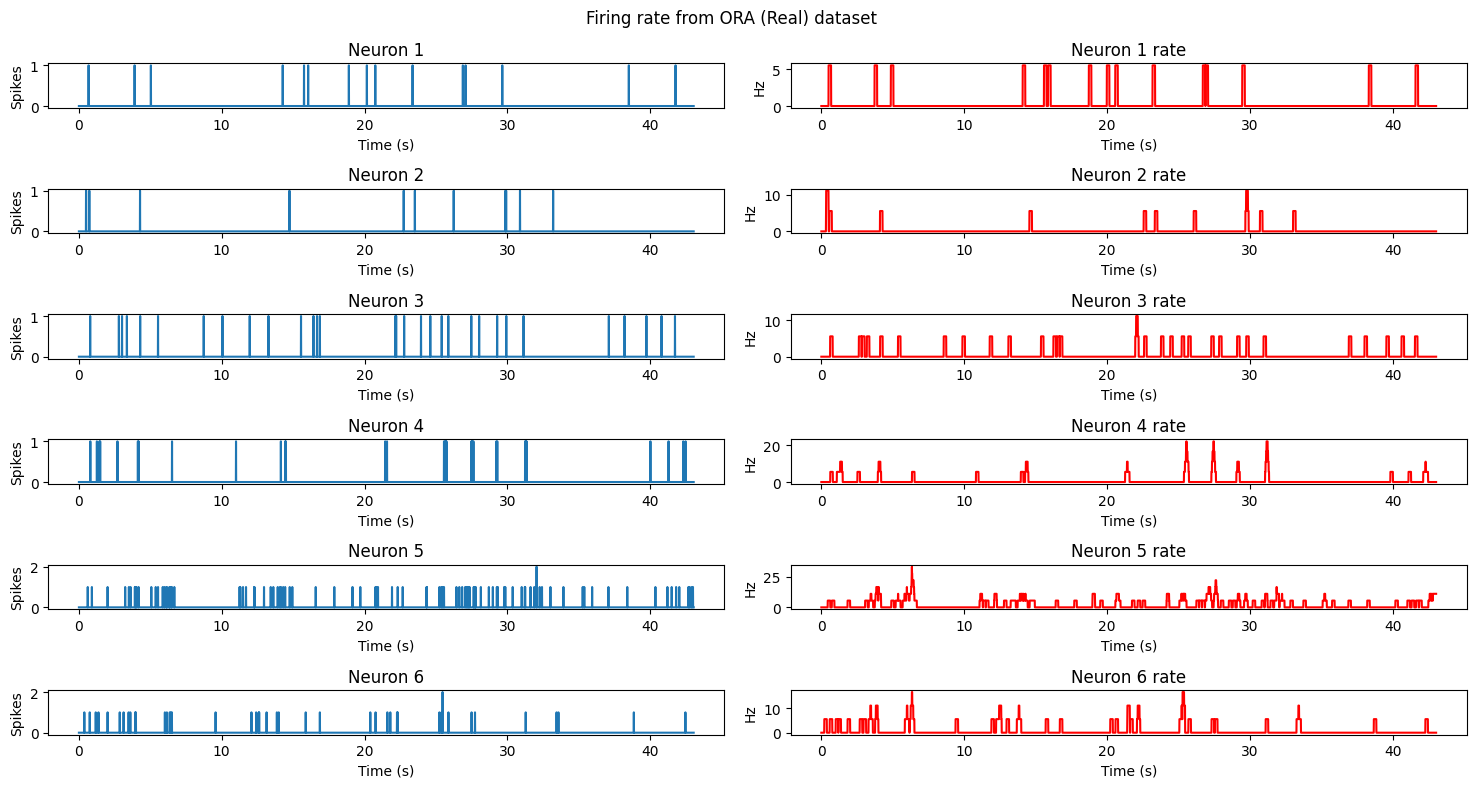

In [105]:
Firing_Rate_EME.display_aggregated_plot(rate_EME)
Firing_Rate_ORA.display_aggregated_plot(rate_ORA)

### Neural rate for first 4 trials

In [106]:
selected_trials = 4
trial_index = (Trials_EME <= selected_trials) # First 4 trials
trial_index_ORA = (Trials_ORA <= selected_trials) # First 4 trials

temp_spikes_EME = []
temp_spikes_ORA =  []

for neuron in Spikes_EME.T:
    temp_spikes_EME.append(neuron[trial_index])

for neuron in Spikes_ORA.T:
    temp_spikes_ORA.append(neuron[trial_index_ORA])

In [107]:
__Firing_Rate_EME = Fire_Rate_Estimation(spikes=np.array(temp_spikes_EME).T, trials=Trials_EME[trial_index], dataset_name="EME (Real)")
__Firing_Rate_ORA = Fire_Rate_Estimation(spikes=np.array(temp_spikes_ORA).T, trials=Trials_ORA[trial_index_ORA], dataset_name="ORA (Real)")

__rate_EME = __Firing_Rate_EME.Calculate_rate(window_size=.2)
__rate_ORA = __Firing_Rate_ORA.Calculate_rate(window_size=.18)

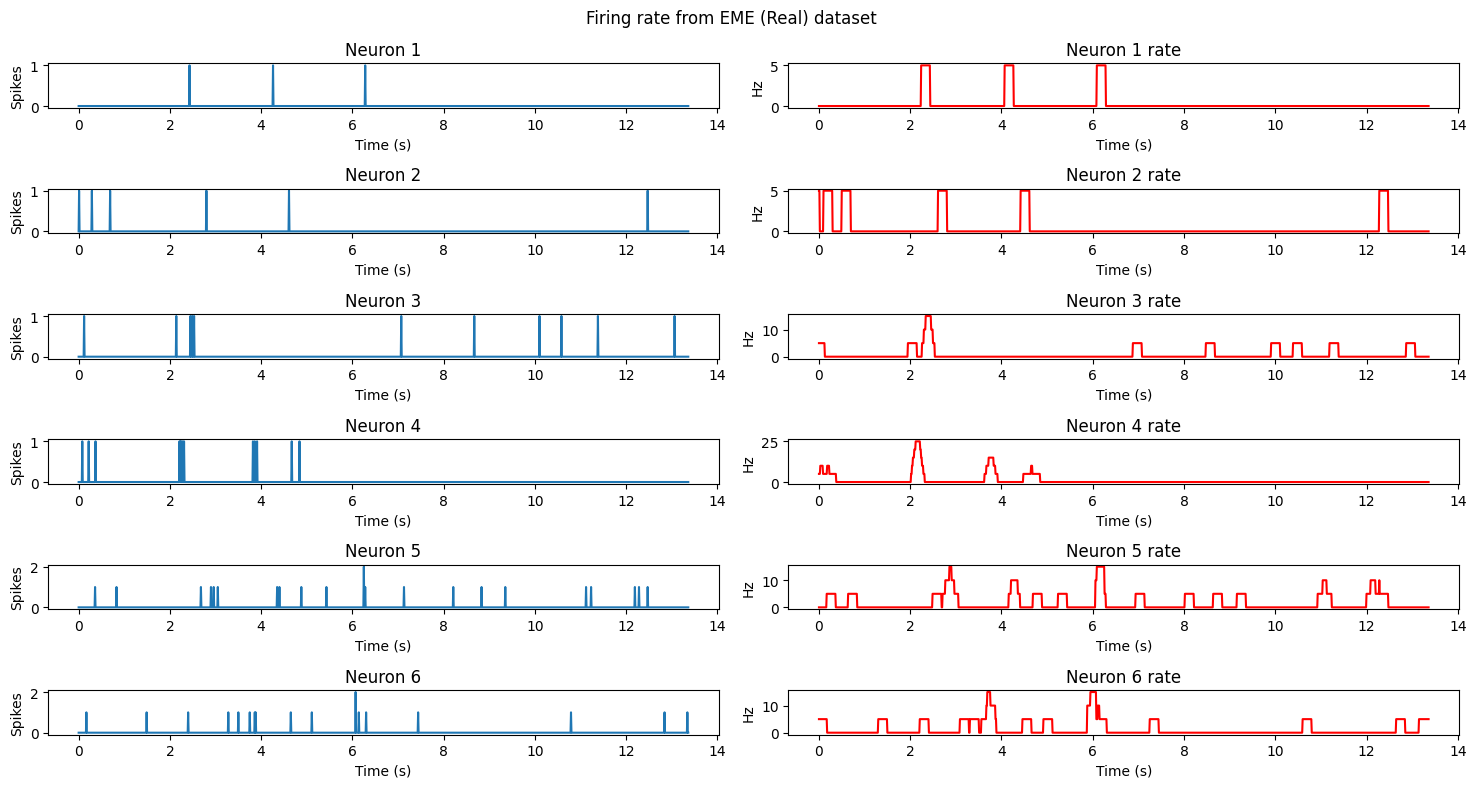

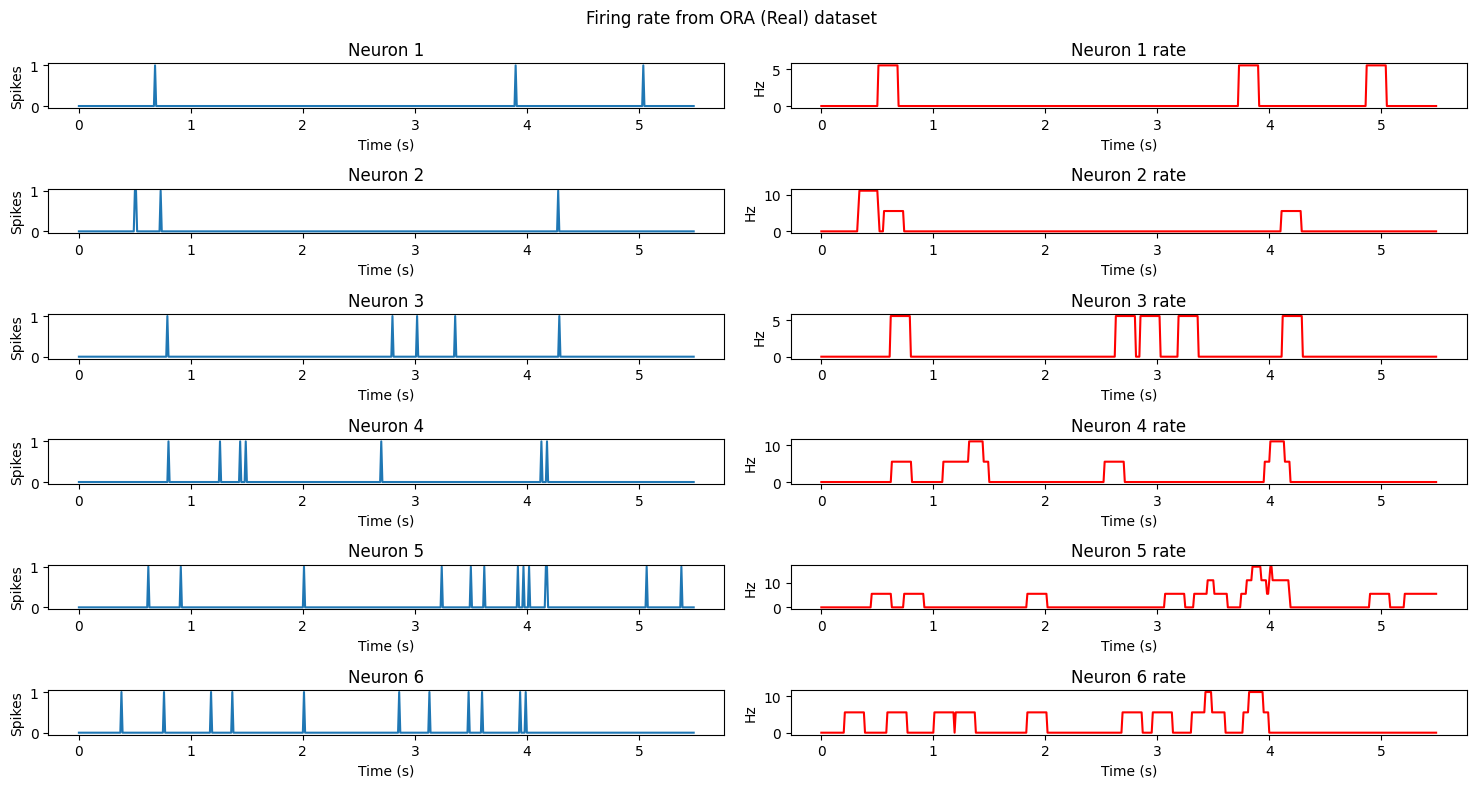

In [108]:
__Firing_Rate_EME.display_aggregated_plot(__rate_EME)
__Firing_Rate_ORA.display_aggregated_plot(__rate_ORA)

In [109]:
__Firing_Rate_EME.Calculate_corrolation_coef(__rate_EME)

Corrolation rate and p-Value from EME (Real) Dataset


,Neuron,Correlation Coefficient,P-Value
0,Neuron 1,0.218777,5.950898e-16
1,Neuron 2,0.233625,4.948102e-18
2,Neuron 3,0.226902,4.515279e-17
3,Neuron 4,0.298801,5.614610e-29
4,Neuron 5,0.229024,2.263698e-17
5,Neuron 6,0.229213,2.128455e-17


In [110]:
__Firing_Rate_ORA.Calculate_corrolation_coef(__rate_ORA)

Corrolation rate and p-Value from ORA (Real) Dataset


,Neuron,Correlation Coefficient,P-Value
0,Neuron 1,0.224446,1.039058e-07
1,Neuron 2,0.228586,5.941847e-08
2,Neuron 3,0.216543,2.931520e-07
3,Neuron 4,0.230389,4.642524e-08
4,Neuron 5,0.247409,4.084621e-09
5,Neuron 6,0.214529,3.795201e-07


## Generating Artificial Spike Trains

In [111]:
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

@dataclass
class Neuron_Network_test:
    input_currents: 'np.ndarray'
    spikes: 'np.ndarray'
    trials: 'np.ndarray'
    ds_name: str
    bin_size: float = field(init=False, default=0.01)
    dataset: 'np.ndarray'

    def leaky_if_1(self, selected_trial, selected_neuron, duration=0.8, verbose=True, dt=0.0001):

        # Fixed parameters
        tau = 0.020  # Membrane time constant (s)
        R = 5e7  # Membrane resistance (Ohms)
        U_rest = -0.07  # Resting potential (V)
        theta = 3.055  # Threshold potential for spike (V)
        spike_volt = 10  # Voltage during spike (V)

        # Input currents setup
        if self.input_currents is None:
            raise ValueError("Input currents must be provided.")
        else:
            psc = self.input_currents[:]  # Times of excitatory currents
        U_0 = 0.3
        I_0 = U_0 / R  # Input current (A)

        # Initialization
        index_pscs = np.round(psc / dt).astype(int)  # Indices of pulse times
        n_steps = int(duration / dt)  # Number of simulation steps
        U = np.zeros(n_steps + 1)  # Membrane potential array
        U_plot = np.zeros(n_steps + 1)  # Membrane potential for plotting
        U[0] = U_rest  # Initialize with resting potential
        U_plot[0] = U_rest
        I = np.zeros(n_steps + 1)  # Input current array
        time = np.linspace(0, duration, n_steps + 1)  # Time array
        n_spikes = 0  # Spike counter

        # Simulation
        for i in range(n_steps):
            for k in range(len(psc)):
                if i == index_pscs[k]:
                    I[i] += I_0
            dU = (dt / tau) * (U_rest - U[i] + I[i] * R)
            U[i + 1] = U[i] + dU
            U_plot[i + 1] = U[i + 1]

            # Spike detection
            if U[i + 1] > theta:
                U_plot[i + 1] = spike_volt
                U[i + 1] = U_rest
                n_spikes += 1

        if verbose:
            n_1, neurons = self.dataset.shape
            times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
            trial_index = (self.trials <= selected_trial)

            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            axs[0].plot(time, U_plot, color='black')
            axs[0].axhline(y=theta, color='red', linestyle='--', label=f'Threshold: {theta * 1000:.1f} mV')
            axs[0].set_title(f'LIF Model {self.ds_name} | Spikes: {n_spikes}')
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('Voltage (V)')
            axs[0].grid(True)
            axs[0].legend()

            axs[1].plot(times[:len(self.dataset[trial_index, selected_neuron - 1])],
                        self.dataset[trial_index, selected_neuron - 1])
            axs[1].set_title(f'Real neuron {selected_neuron} {self.ds_name} | Real Spikes: {len(np.where(self.dataset[trial_index, selected_neuron - 1] == 1)[0])}')
            axs[1].set_ylabel('Spikes')
            axs[1].set_xlabel('Time (s)')
            axs[1].grid(True)
            plt.show()
            
            self.evaluate_similarity(selected_trial=selected_trial, selected_neuron=selected_neuron, art_neuron_output=U_plot, threshold=theta)
            

        return time, U_plot
    
    def leaky_if_2(self, selected_trial, selected_neuron, duration=0.2, dt=0.0001, arp=0.06, verbose=True):
        # Fixed parameters
        tau = 0.020  # Membrane time constant (s)
        R = 3e7  # Membrane resistance (Ohms)
        U_rest = -0.07  # Resting potential (V)
        theta = 3.055  # Threshold potential for spike (V)
        spike_volt = 10  # Voltage during spike (V)

        psc = self.input_currents[:]  # Times of excitatory currents
        U_0 = 0.3
        I_0 = U_0 / R  # Input current (A)
        # I_0 = 1e-8  # Input current (A)

        # Initialization
        # arp = 0.060
        
        background = 3e-9
        
        index_pscs = np.round(psc / dt).astype(int)  # Indices of pulse times
        n_steps = int(duration / dt)  # Number of simulation steps
        U = np.zeros(n_steps + 1)  # Membrane potential array
        U_plot = np.zeros(n_steps + 1)  # Membrane potential for plotting
        U[0] = U_rest  # Initialize with resting potential
        U_plot[0] = U_rest
        I = np.zeros(n_steps + 1)  # Input current array
        time = np.linspace(0, duration, n_steps + 1)  # Time array
        n_spikes = 0  # Spike counter
        t_spike = 0 # Addition with respect to LeakyIF_1: Intial time since last spike -will be used in the implementation of the refractory period
        
        # Background noise drawn from a normal distribution (central limit)
        randI = background * np.random.randn(1, n_steps)

        # Simulation
        # print(randI)
        for i in range(n_steps):
            # if i >= 500 and i <= 1200:
            #     continue
            for k in range(len(psc)):
                if i == index_pscs[k]:
                    I[i] += I_0
                    
                    
            dU = (dt / tau) * (U_rest - U[i] + I[i] * R + randI[0][i] * R)
            U[i + 1] = U[i] + dU
            U_plot[i + 1] = U[i + 1]
            
            # Spike detection
            if U[i + 1] > theta:
                # theta += .0001
                if n_spikes > 0:
                    if time[i] >= (t_spike + arp):
                        U_plot[i + 1] = spike_volt
                        U[i + 1] = U_rest
                        n_spikes += 1
                    else:
                        U[i + 1] = U[i]
                        U_plot[i + 1] = U[i + 1]
                else:
                    U_plot[i + 1] = spike_volt
                    U[i + 1] = U_rest
                    t_spike = time[i]
                    n_spikes += 1
                
        if verbose:
            n_1, neurons = self.dataset.shape
            times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
            trial_index = (self.trials <= selected_trial)
            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            axs[0].plot(time, U_plot, color='black')
            axs[0].axhline(y=theta, color='red', linestyle='--', label=f'Threshold: {theta * 1000:.1f} mV')
            axs[0].set_title(f'Leaky integrate-and-fire model {self.ds_name}. Number of spike(s): {n_spikes}')
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('Voltage (U) (V)')
            axs[0].grid(True)
            axs[0].legend()
            # print(self.dataset[selected_trial, selected_neuron - 1])
            # axs[1].eventplot(np.where(self.spikes == 1)[0] * dt, color='black')
            axs[1].plot(times[:len(self.dataset[trial_index, selected_neuron - 1])], self.dataset[trial_index, selected_neuron - 1])
            axs[1].set_title(f'Real neuron {selected_neuron} {self.ds_name}. Number of spike(s): {len(np.where(self.dataset[trial_index, selected_neuron - 1] == 1)[0])}')
            axs[1].set_ylabel('Spikes')
            axs[1].set_xlabel('Time (s)')
            axs[1].grid(True)
            axs[1].legend()
            plt.show()
            
            self.evaluate_similarity(selected_trial=selected_trial, selected_neuron=selected_neuron, art_neuron_output=U_plot, threshold=theta)

        return time, U_plot

    def leaky_if_3(self, selected_trial, selected_neuron, duration=0.2, dt=0.0001, ipsc=np.array([]), arp=.06, verbose=True):
        # PARAMETER SETUP
        # Fixed parameters
        tau = 0.020  # Membrane time constant (seconds)
        R = 3e7      # Membrane resistance (ohms)
        U_rest = -0.07  # Resting potential (volts)
        theta = 3.055  # Threshold for spike initiation (volts)
        spikeVolt = 10  # Spike value (volts)
        # arp = 0.006  # Absolute refractory period (seconds)
        backgroundI = 3e-9  # Background noise (amps)
        tau_adapt = 0.5  # Decay rate of adaptive threshold
        increase_threshold = 3.255  # Threshold increase after spike (volts)

        
        psc = self.input_currents[:]  # Times of excitatory currents
        U_0 = 0.3
        I_0 = U_0 / R  # Input current (A)
        # ipsc = np.array([])
        # ipsc = np.arange(0, .5, .005)
            

        # MODEL
        n_pcs = len(psc)
        n_ipcs = len(ipsc)
        index_pscs = np.round(psc / dt).astype(int)
        index_ipscs = np.round(ipsc / dt).astype(int)
        n_steps = int(duration / dt)
        
        U = np.zeros(n_steps + 1)
        U_plot = np.zeros(n_steps + 1)
        U[0] = U_rest
        U_plot[0] = U_rest
        
        I = np.zeros(n_steps + 1)
        t_spike = 0
        n_spikes = 0
        time = np.linspace(0, duration, n_steps + 1)
        randI = backgroundI * np.random.normal(0, 1, n_steps)
        theta_adapt = np.full(n_steps + 1, theta)

        # SIMULATION
        for i in range(n_steps):
            for k in range(n_pcs):
                if i == index_pscs[k]:
                    I[i] += I_0

            for k in range(n_ipcs):
                if i == index_ipscs[k]:
                    I[i] -= I_0

            dU = (dt / tau) * (U_rest - U[i] + I[i] * R + randI[i] * R)
            U[i + 1] = U[i] + dU
            U_plot[i + 1] = U[i + 1]

            if U[i + 1] > theta_adapt[i]:
                if n_spikes > 0 and time[i] < t_spike + arp:
                    U[i + 1] = U[i]
                    U_plot[i + 1] = U[i + 1]
                else:
                    U_plot[i + 1] = spikeVolt
                    U[i + 1] = U_rest
                    t_spike = time[i]
                    n_spikes += 1
                    theta_adapt[i + 1] = theta_adapt[i] + increase_threshold
            else:
                theta_adapt[i + 1] = theta_adapt[i] + (dt / tau_adapt) * (theta - theta_adapt[i])
        
        if verbose:        
            n_1, neurons = self.dataset.shape
            times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
            trial_index = (self.trials <= selected_trial)
            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            axs[0].plot(time, U_plot, color='black')
            axs[0].axhline(y=theta, color='red', linestyle='--', label=f'Threshold: {theta * 1000:.1f} mV')
            axs[0].set_title(f'Leaky integrate-and-fire model {self.ds_name}. Number of spike(s): {n_spikes}')
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('Voltage (U) (V)')
            axs[0].grid(True)
            axs[0].legend()
            # print(self.dataset[selected_trial, selected_neuron - 1])
            # axs[1].eventplot(np.where(self.spikes == 1)[0] * dt, color='black')
            axs[1].plot(times[:len(self.dataset[trial_index, selected_neuron - 1])], self.dataset[trial_index, selected_neuron - 1])
            axs[1].set_title(f'Real neuron {selected_neuron} {self.ds_name}. Number of spike(s): {len(np.where(self.dataset[trial_index, selected_neuron - 1] == 1)[0])}')
            axs[1].set_ylabel('Spikes')
            axs[1].set_xlabel('Time (s)')
            axs[1].grid(True)
            axs[1].legend()
            plt.show()
            
            self.evaluate_similarity(selected_trial=selected_trial, selected_neuron=selected_neuron, art_neuron_output=U_plot, threshold=theta)

            plt.figure()
            plt.plot(time, theta_adapt, color='red')
            plt.axhline(y=theta, color='red', linestyle='--')
            plt.title(f"Threshold dynamics. Rest threshold: {theta * 1000} mV - ({self.ds_name})")
            plt.xlabel("Time (s)")
            plt.ylabel(f"Threshold (U), number of spikes = {n_spikes}")
            plt.grid()
            plt.show()

        return time, U_plot

    def evaluate_similarity(self, selected_trial, selected_neuron, art_neuron_output, threshold):
        trial_index = (self.trials <= selected_trial)
        real_spike_train = self.dataset[trial_index, selected_neuron - 1]

        # Calculate ISI and Spike Count Error
        artificial_spikes = np.where(art_neuron_output >= threshold)[0]
        real_spikes = np.where(real_spike_train == 1)[0]

        real_isi = np.diff(real_spikes) * self.bin_size
        artificial_isi = np.diff(artificial_spikes) * self.bin_size

        spike_count_error = abs(len(real_spikes) - len(artificial_spikes)) / len(real_spikes)

        # Visualization
        plt.figure(figsize=(12, 6))
        plt.hist(real_isi, bins=20, alpha=.5, label='Real ISI')
        plt.hist(artificial_isi, bins=20, alpha=.5, label='Artificial ISI')
        plt.title(f'ISI Comparison for Neuron {selected_neuron} - ({self.ds_name})')
        plt.xlabel('Interspike Interval (s)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()
        
        print("spike_count_error", spike_count_error)
        print("real_isi_mean", np.mean(real_isi))
        print("artificial_isi_mean", np.mean(artificial_isi))

        return {
            "spike_count_error": spike_count_error,
            "real_isi_mean": np.mean(real_isi),
            "artificial_isi_mean": np.mean(artificial_isi)
        }
    
    def leaky_if_2_test(self, selected_trial, selected_neuron, duration=0.2, dt=0.0001, arp=0.060, verbose=True):
        # Parameters for the Integrate-and-Fire neuron
        V_reset = -65.0  # Reset potential (mV)
        V_th = -0.055    # Threshold potential (mV)
        tau_m = 20.0     # Membrane time constant (ms)
        R_m = 10.0       # Membrane resistance (MΩ)
        I_mean = 1.5     # Mean input current (µA)
        dt = 0.01         # Time step (ms)
        simulation_time = 1000  # Total simulation time (ms)
        n_neurons = 6
        
        # index_pscs = np.round(psc / dt).astype(int)  # Indices of pulse times
        n_steps = int(duration / dt)  # Number of simulation steps
        U = np.zeros(n_steps + 1)  # Membrane potential array
        U_plot = np.zeros(n_steps + 1)  # Membrane potential for plotting
        # U[0] = U_rest  # Initialize with resting potential
        # U_plot[0] = U_rest
        I = np.zeros(n_steps + 1)  # Input current array
        time = np.linspace(0, duration, n_steps + 1)  # Time array
        n_spikes = 0  # Spike counter
        t_spike = 0 # Addition with respect to LeakyIF_1: Intial time since last spike -will be used in the implementation of the refractory period
        
        # Simulate a single neuron using Integrate-and-Fire model
        def integrate_and_fire(I_ext):
            V = V_reset
            spikes = []  # Times when spikes occur

            for t in range(len(I_ext)):
                V += (-(V - V_reset) + R_m * I_ext[t]) * dt / tau_m

                if V >= V_th:
                    spikes.append(t * dt)
                    V = V_reset
                else:
                    spikes.append(0)

            return spikes
                
        spikes = integrate_and_fire(self.input_currents)
        # spike_trains[f"Neuron {neuron + 1}"] = spikes
        
        if verbose:
            n_1, neurons = self.dataset.shape
            times = np.arange(0, (n_1 - 1) * self.bin_size + self.bin_size, self.bin_size)
            trial_index = (self.trials == selected_trial)
            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            # axs[0].plot(time, spikes, color='black')
            axs[0].eventplot(spikes, color='black')
            axs[0].axhline(y=V_th, color='red', linestyle='--', label=f'Threshold: {V_th * 1000:.1f} mV')
            axs[0].set_title(f'Leaky integrate-and-fire model {self.ds_name}. Number of spike(s): {n_spikes}')
            axs[0].set_xlabel('Time (s)')
            axs[0].set_ylabel('Voltage (U) (V)')
            axs[0].grid(True)
            axs[0].legend()
            # print(self.dataset[selected_trial, selected_neuron - 1])
            # axs[1].eventplot(np.where(self.spikes == 1)[0] * dt, color='black')
            axs[1].plot(times[:len(self.dataset[:, selected_neuron - 1])], self.dataset[:, selected_neuron - 1])
            axs[1].set_title(f'Real neuron {selected_neuron} {self.ds_name}. Number of spike(s): {len(np.where(self.dataset[:, selected_neuron - 1] == 1)[0])}')
            axs[1].set_ylabel('Spikes')
            axs[1].set_xlabel('Time (s)')
            axs[1].grid(True)
            axs[1].legend()
            plt.show()
            
            self.evaluate_similarity(selected_trial=selected_trial, selected_neuron=selected_neuron, art_neuron_output=U_plot, threshold=V_th)

        return time, spikes

In [112]:
# Store Artificial neurons
art_neurons_EME = [
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
]
art_neurons_ORA = [
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
    np.zeros(10),
]

### Generating artificial neurons (EME)

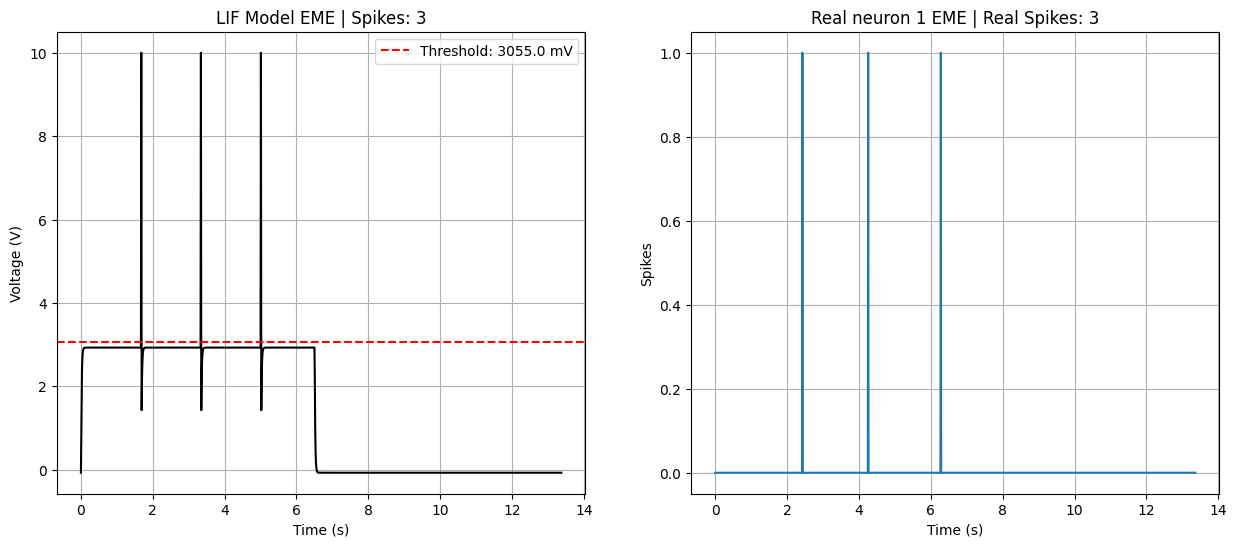

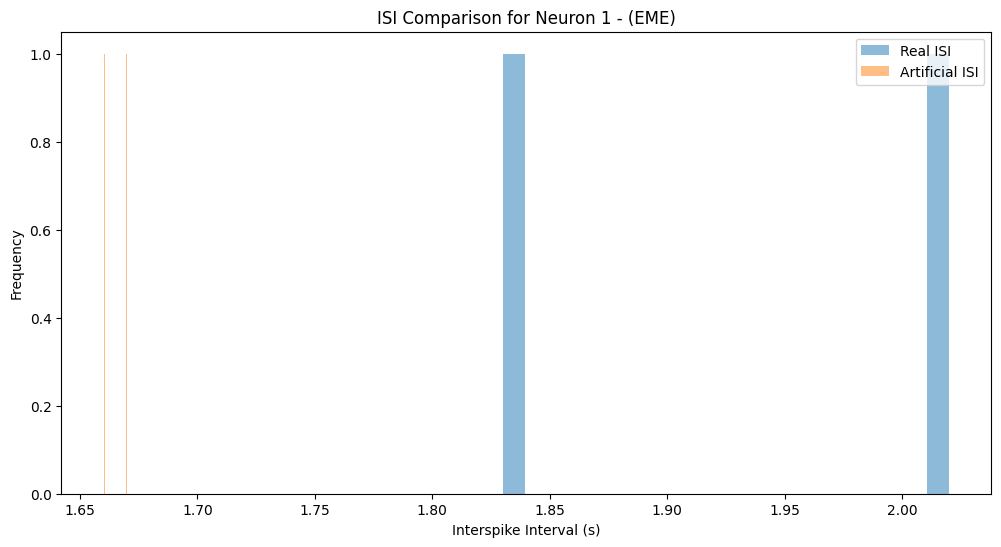

spike_count_error 0.0
real_isi_mean 1.925
artificial_isi_mean 1.665


In [113]:
time = len(Spikes_EME[trial_index, 0]) * .01
EXT_INPUT_EME = np.arange(0, 6.5, .0009994)

LIF_EME_neurons1 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 0], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron1_EME = LIF_EME_neurons1.leaky_if_1(selected_trial=selected_trials, selected_neuron=1, duration=time, dt=.01)
art_neurons_EME[0] = artificial_neuron1_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron1_EME[1][:-1])

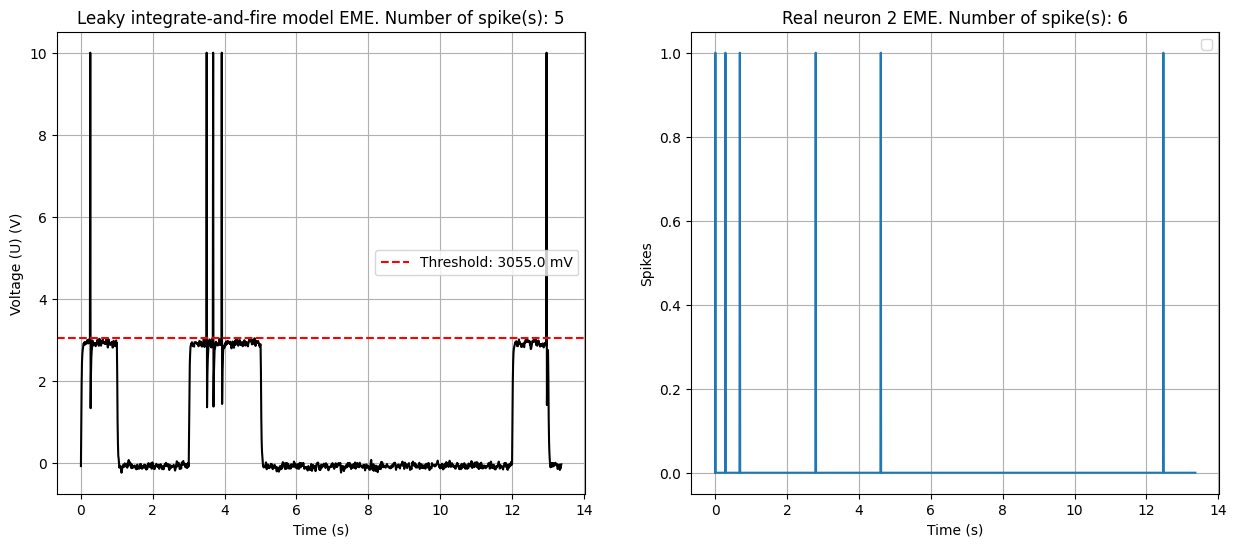

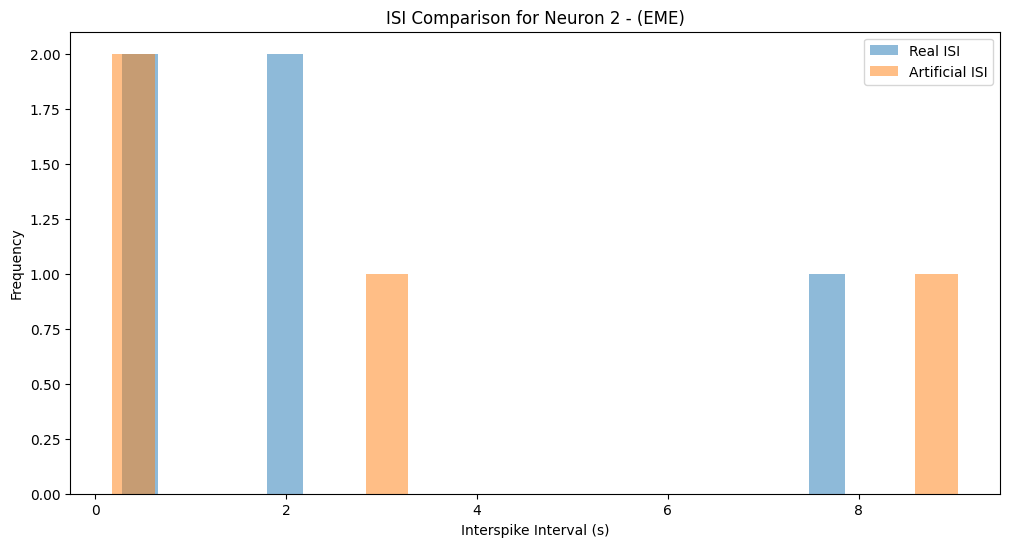

spike_count_error 0.16666666666666666
real_isi_mean 2.492
artificial_isi_mean 3.1750000000000003


In [114]:
time = len(Spikes_EME[trial_index, 1]) * .01
EXT_INPUT_EME = np.concatenate((
    np.arange(0, 1, .000996),
    np.arange(3, 5, .0009989),
    np.arange(12, 13, .00099895)
    ))
LIF_EME_neurons2 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 1], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron2_EME = LIF_EME_neurons2.leaky_if_2(selected_trial=selected_trials, selected_neuron=2, duration=time, dt=.01)
art_neurons_EME[1] = artificial_neuron2_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron2_EME[1][:-1])

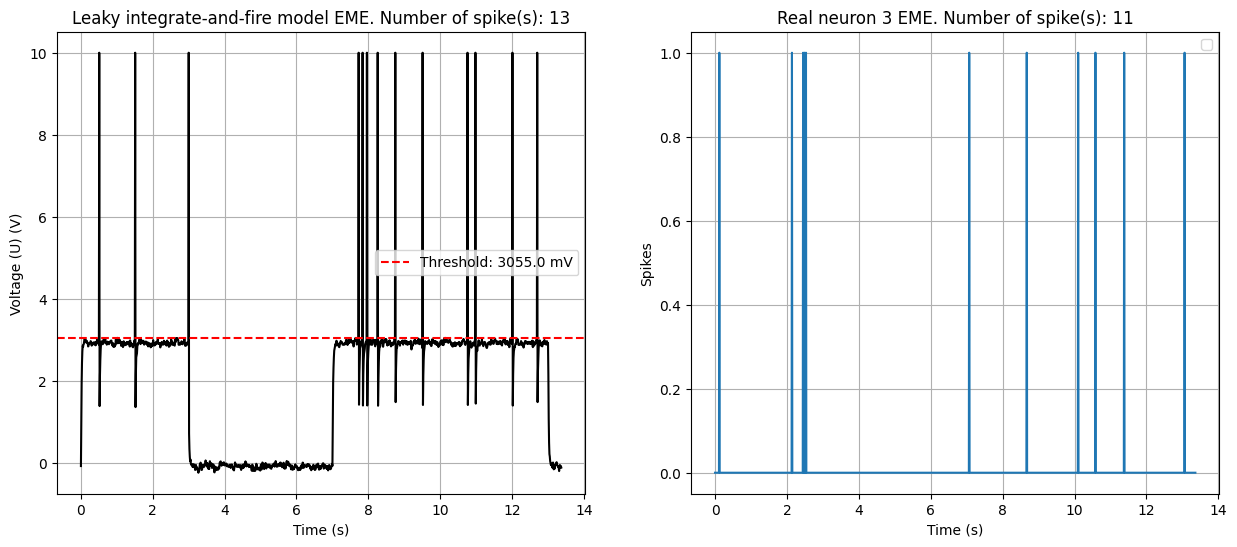

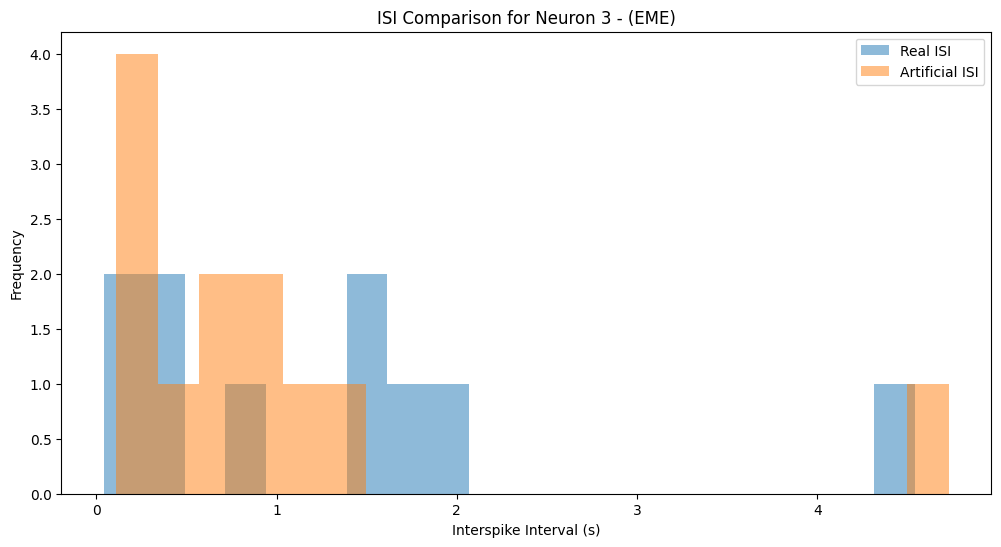

spike_count_error 0.18181818181818182
real_isi_mean 1.294
artificial_isi_mean 1.0158333333333334


In [115]:
time = len(Spikes_EME[trial_index, 2]) * .01
EXT_INPUT_EME = np.concat((
    np.arange(0, 3, .000998),
    np.arange(7, 13, .0009992),
    ))
LIF_EME_neurons3 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 2], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron3_EME = LIF_EME_neurons3.leaky_if_2(selected_trial=4, selected_neuron=3, duration=time, dt=.01)
art_neurons_EME[2] = artificial_neuron3_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron3_EME[1][:-1])

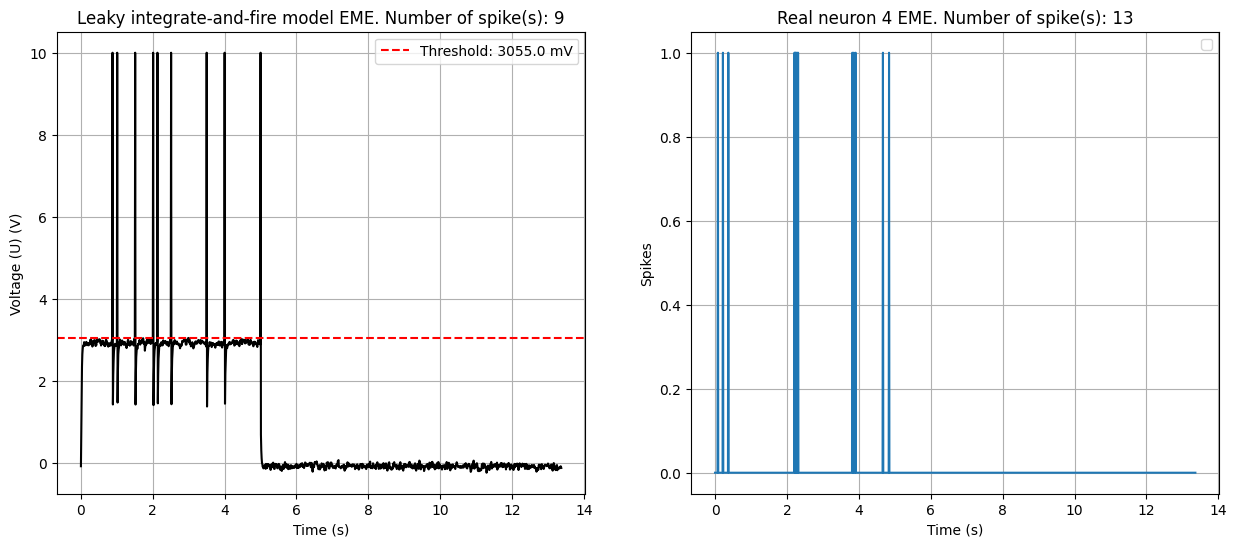

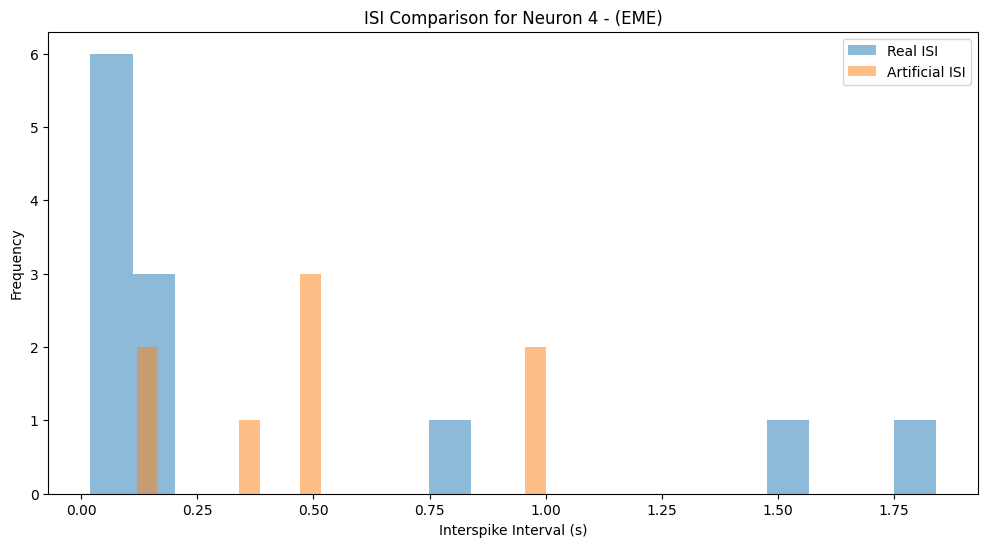

spike_count_error 0.3076923076923077
real_isi_mean 0.39666666666666667
artificial_isi_mean 0.515


In [116]:
time = len(Spikes_EME[trial_index, 3]) * .01
EXT_INPUT_EME = np.arange(0, 5, .000998)
LIF_EME_neurons4 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 3], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron4_EME = LIF_EME_neurons4.leaky_if_2(selected_trial=4, selected_neuron=4, duration=time, dt=.01)
art_neurons_EME[3] = artificial_neuron4_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron4_EME[1][:-1])

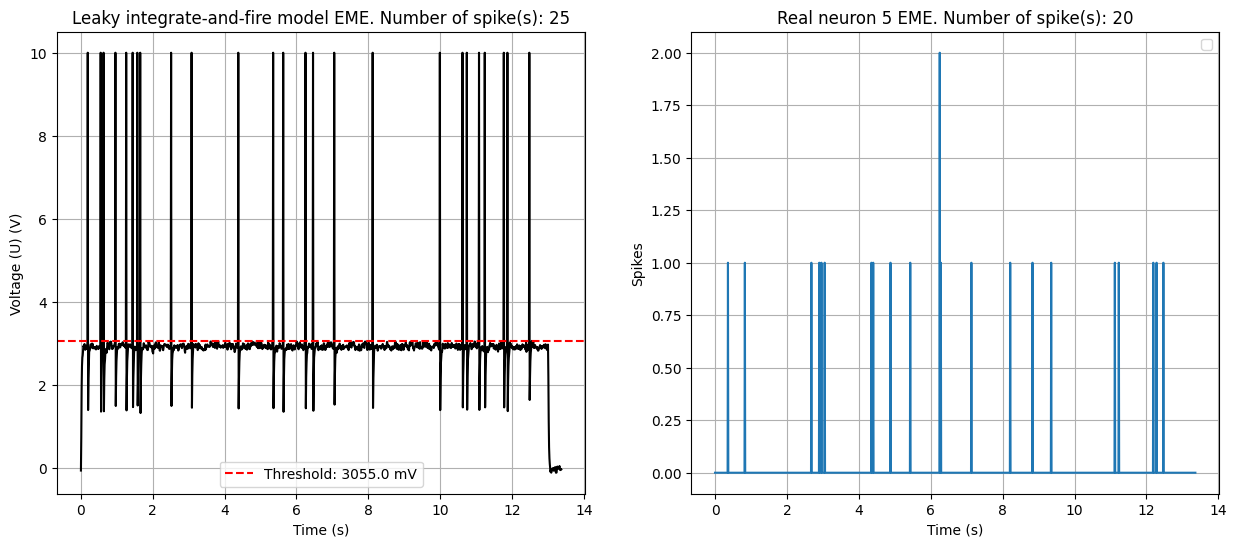

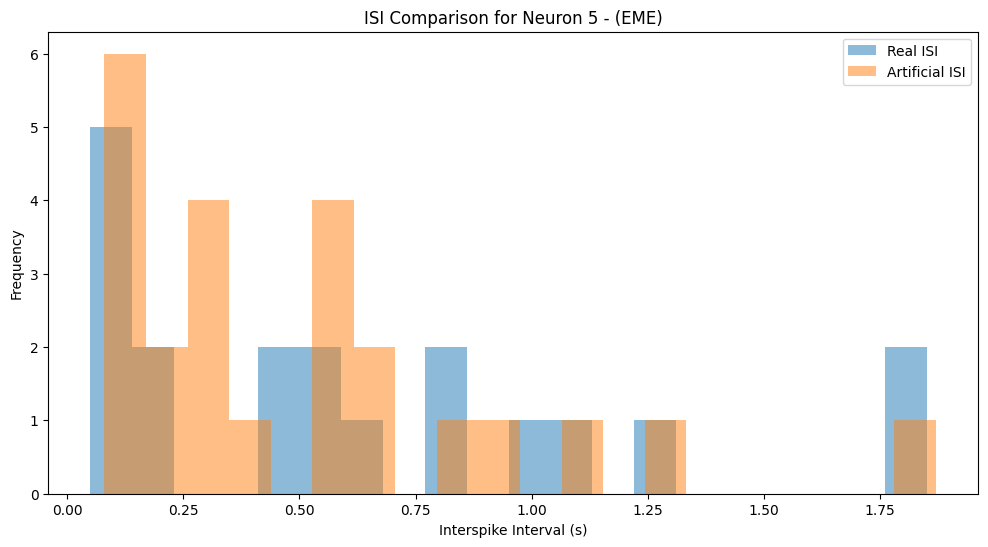

spike_count_error 0.25
real_isi_mean 0.6373684210526317
artificial_isi_mean 0.5120833333333333


In [117]:
time = len(Spikes_EME[trial_index, 4]) * .01
EXT_INPUT_EME = np.arange(0, 13, .0009984)
LIF_EME_neurons5 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 4], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron5_EME = LIF_EME_neurons5.leaky_if_2(selected_trial=4, selected_neuron=5, duration=time, dt=.01)
art_neurons_EME[4] = artificial_neuron5_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron5_EME[1][:-1])

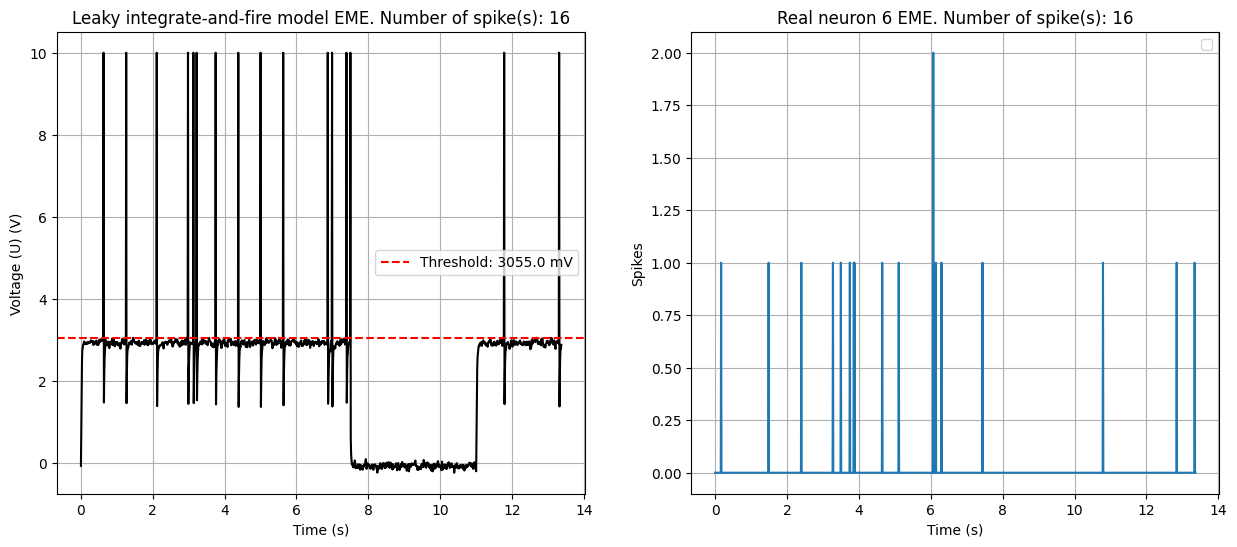

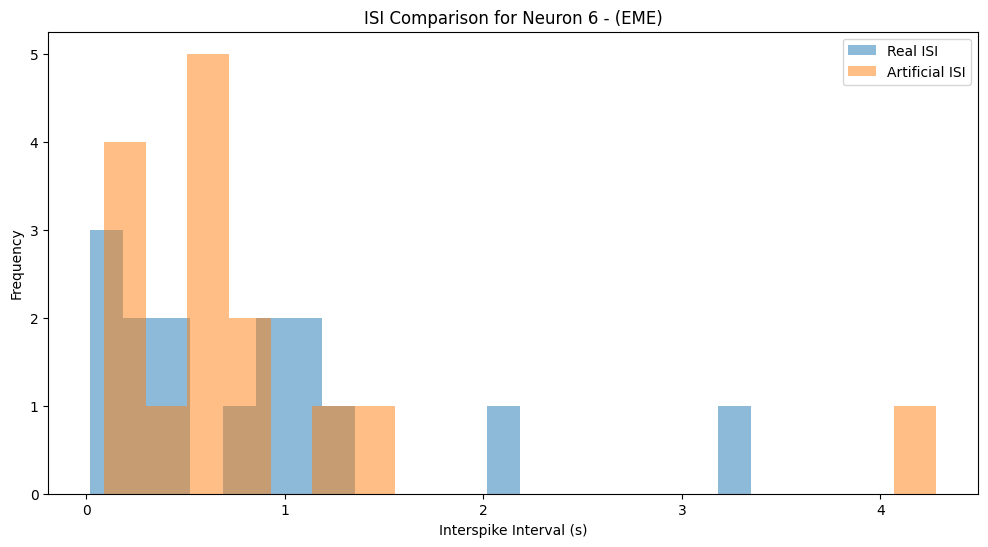

spike_count_error 0.0
real_isi_mean 0.8780000000000001
artificial_isi_mean 0.8453333333333334


In [118]:
time = len(Spikes_EME[trial_index, 5]) * .01
EXT_INPUT_EME = np.concat((
    np.arange(0, 7.5, .0009984),
    np.arange(11, time, .0009987),
    ))
LIF_EME_neurons6 = Neuron_Network_test(input_currents=EXT_INPUT_EME, spikes=Spikes_EME[trial_index, 5], trials=Trials_EME, ds_name="EME", dataset=Spikes_EME)
artificial_neuron6_EME = LIF_EME_neurons6.leaky_if_2(selected_trial=4, selected_neuron=6, duration=time, dt=.01)
art_neurons_EME[5] = artificial_neuron6_EME[1][:-1]
# art_neurons_EME.append(artificial_neuron6_EME[1][:-1])

### Generating ORA

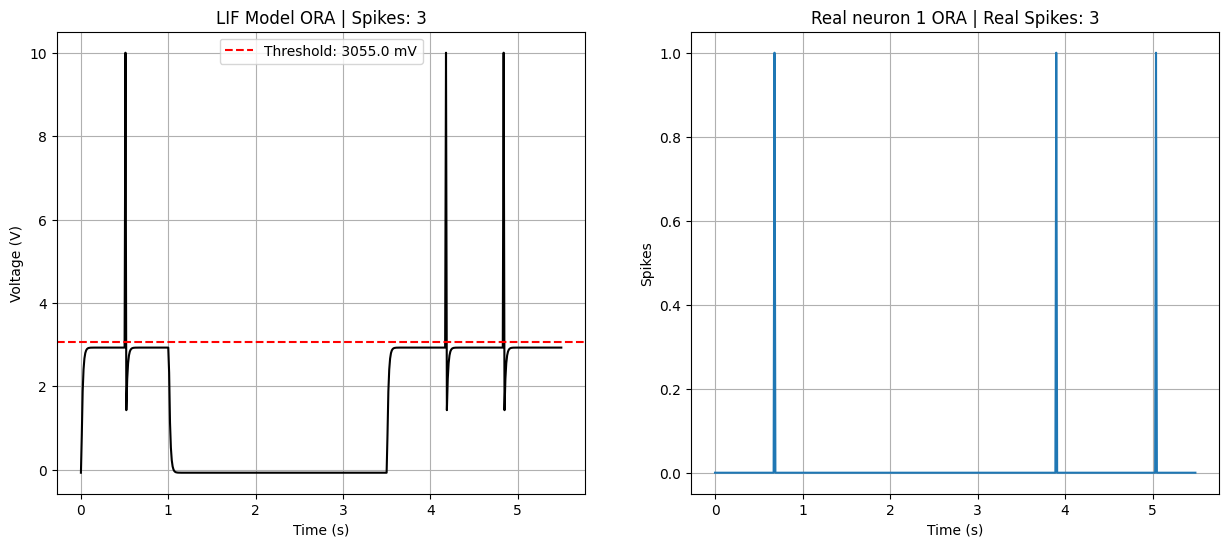

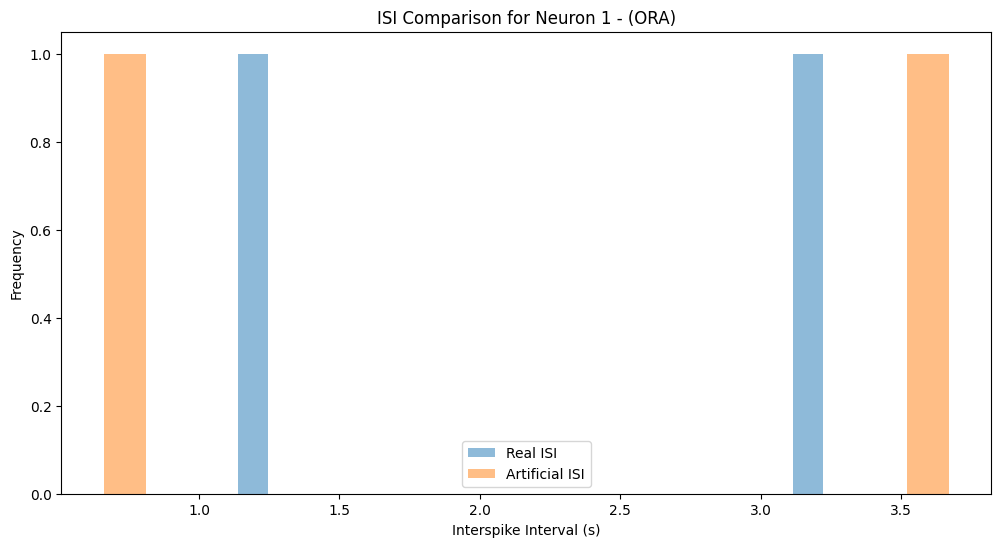

spike_count_error 0.0
real_isi_mean 2.18
artificial_isi_mean 2.165


In [119]:
time = len(Spikes_ORA[trial_index_ORA, 0]) * .01
EXT_INPUT_ORA = np.concat((
    np.arange(0, 1, .000998),
    np.arange(3.5, time, .0009985),
    ))

LIF_ORA_neurons1 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 0], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron1_ORA = LIF_ORA_neurons1.leaky_if_1(selected_trial=selected_trials, selected_neuron=1, duration=time, dt=.01)
art_neurons_ORA[0] = artificial_neuron1_ORA[1][:-1]

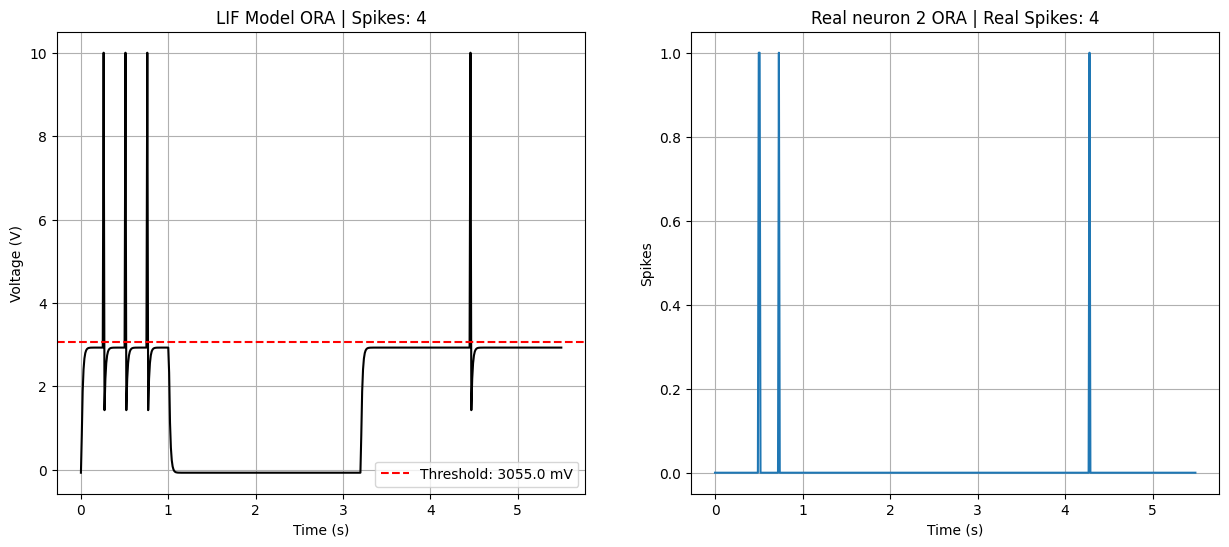

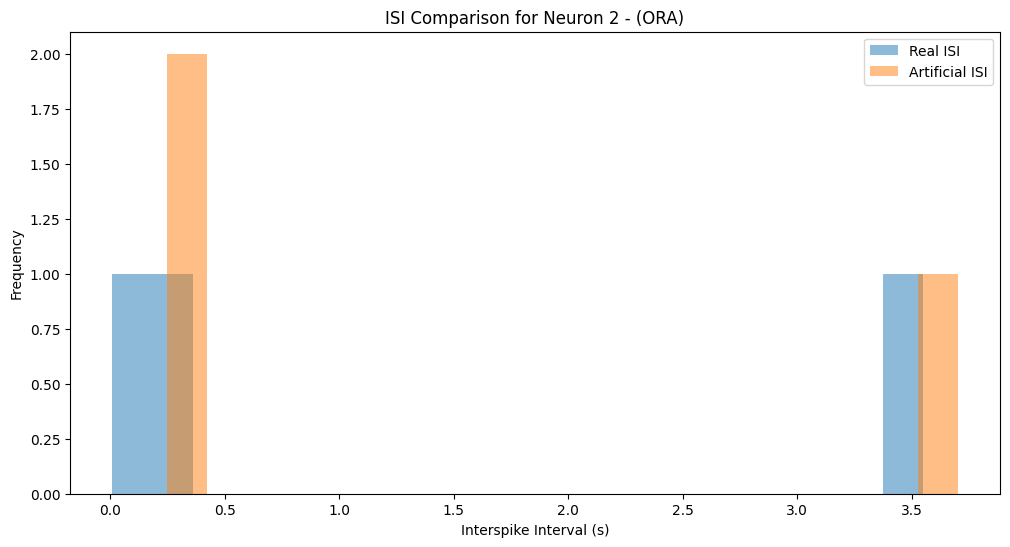

spike_count_error 0.0
real_isi_mean 1.26
artificial_isi_mean 1.4000000000000001


In [120]:
time = len(Spikes_ORA[trial_index_ORA, 1]) * .01
EXT_INPUT_ORA = np.concat((
    np.arange(0, 1, .000996),
    np.arange(3.2, time, .0009992),
    ))

LIF_ORA_neurons2 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 1], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron2_ORA = LIF_ORA_neurons2.leaky_if_1(selected_trial=selected_trials, selected_neuron=2, duration=time, dt=.01)
art_neurons_ORA[1] = artificial_neuron2_ORA[1][:-1]

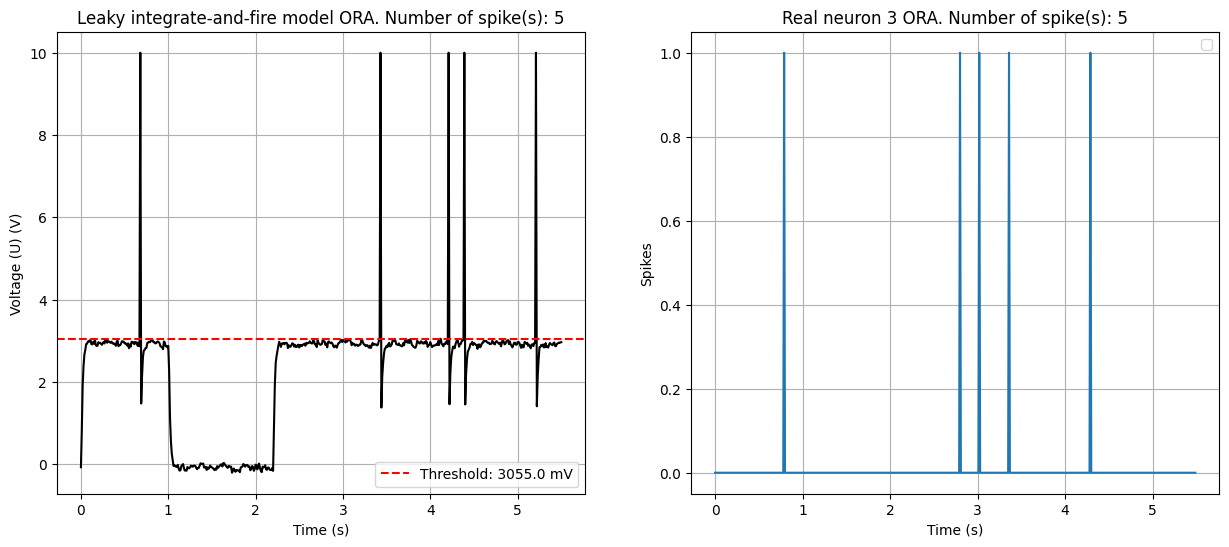

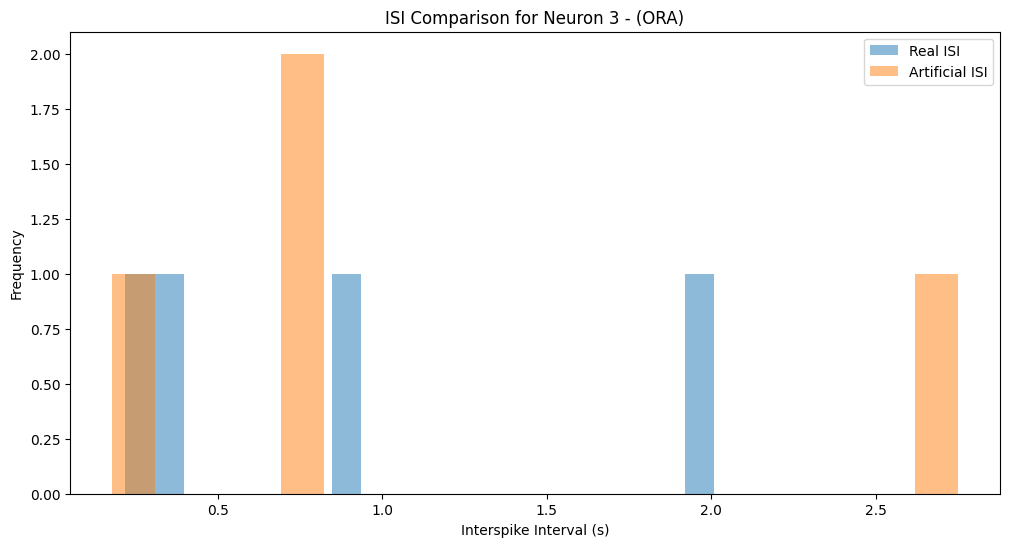

spike_count_error 0.0
real_isi_mean 0.8750000000000001
artificial_isi_mean 1.1325


In [121]:
time = len(Spikes_ORA[trial_index_ORA, 2]) * .01
EXT_INPUT_ORA = np.concat((
    np.arange(0, 1, .0009985),
    np.arange(2.2, time, .000999),
    ))

LIF_ORA_neurons3 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 2], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron3_ORA = LIF_ORA_neurons3.leaky_if_2(selected_trial=selected_trials, selected_neuron=3, duration=time, dt=.01)
art_neurons_ORA[2] = artificial_neuron3_ORA[1][:-1]

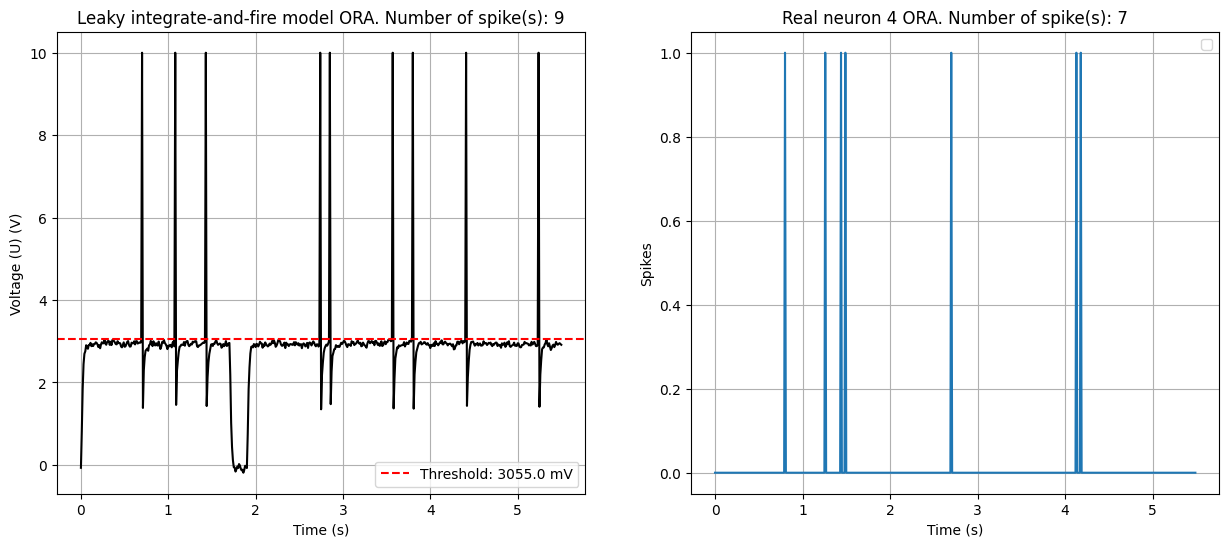

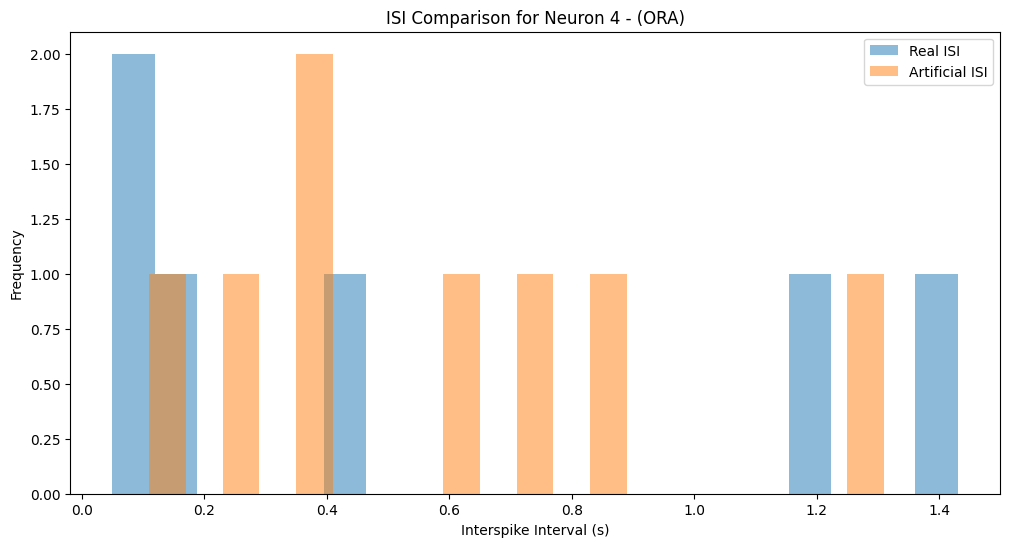

spike_count_error 0.2857142857142857
real_isi_mean 0.5633333333333334
artificial_isi_mean 0.5675


In [122]:
time = len(Spikes_ORA[trial_index_ORA, 3]) * .01
EXT_INPUT_ORA = np.concat((
    np.arange(0, 1.7, .0009972),
    np.arange(1.9, time, .0009988),
    ))

LIF_ORA_neurons4 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 3], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron4_ORA = LIF_ORA_neurons4.leaky_if_2(selected_trial=selected_trials, selected_neuron=4, duration=time, dt=.01)
art_neurons_ORA[3] = artificial_neuron4_ORA[1][:-1]

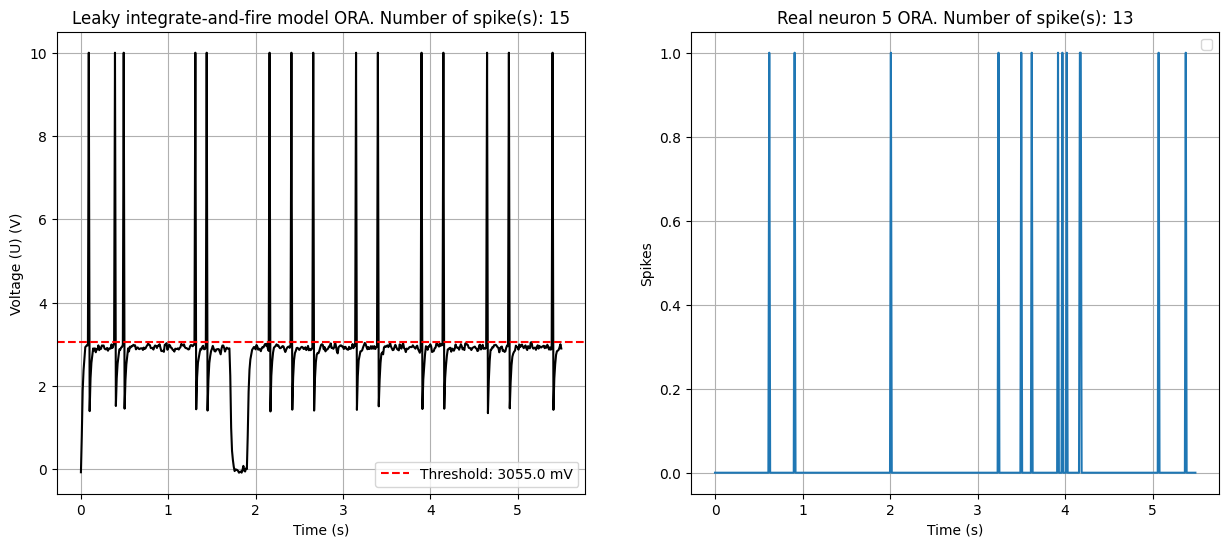

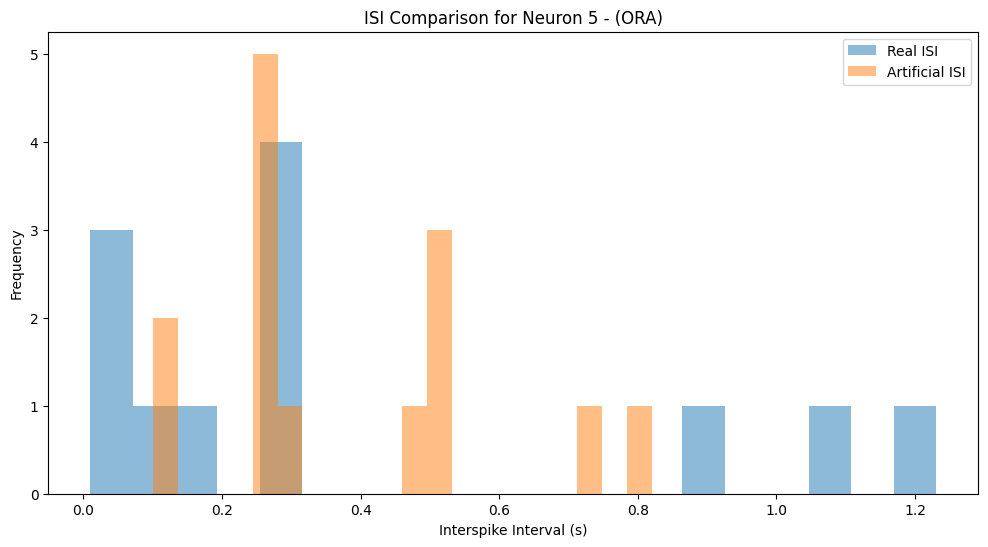

spike_count_error 0.15384615384615385
real_isi_mean 0.39666666666666656
artificial_isi_mean 0.37928571428571434


In [123]:
time = len(Spikes_ORA[trial_index_ORA, 4]) * .01
EXT_INPUT_ORA = np.concat((
    np.arange(0, 1.7, .0009979),
    np.arange(1.9, time, .000996),
    ))

LIF_ORA_neurons5 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 4], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron5_ORA = LIF_ORA_neurons5.leaky_if_2(selected_trial=selected_trials, selected_neuron=5, duration=time, dt=.01)
art_neurons_ORA[4] = artificial_neuron5_ORA[1][:-1]

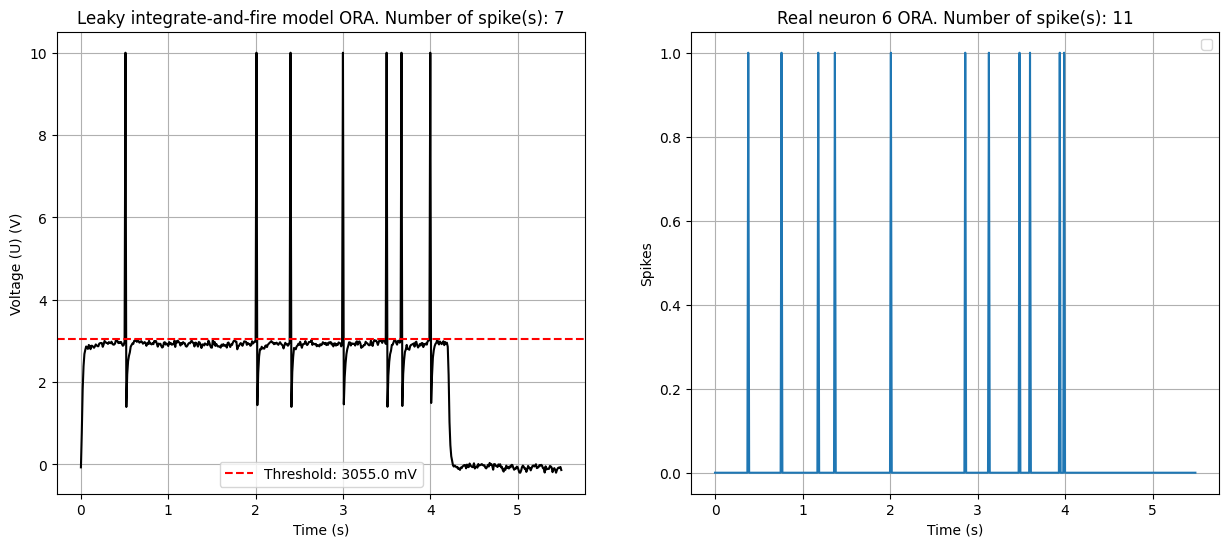

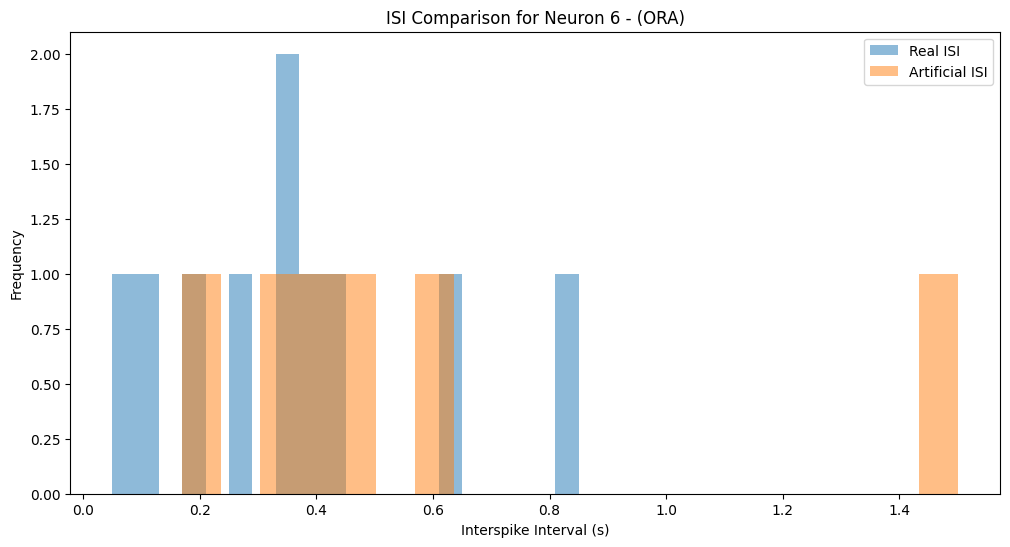

spike_count_error 0.36363636363636365
real_isi_mean 0.361
artificial_isi_mean 0.5816666666666667


In [124]:
time = len(Spikes_ORA[trial_index_ORA, 5]) * .01
EXT_INPUT_ORA = np.arange(0, 4.2, .000998)

LIF_ORA_neurons6 = Neuron_Network_test(input_currents=EXT_INPUT_ORA, spikes=Spikes_ORA[trial_index_ORA, 5], trials=Trials_ORA, ds_name="ORA", dataset=Spikes_ORA)
artificial_neuron6_ORA = LIF_ORA_neurons6.leaky_if_2(selected_trial=selected_trials, selected_neuron=6, duration=time, dt=.01)
art_neurons_ORA[5] = artificial_neuron6_ORA[1][:-1]

## Optimal window size for Artificial neurons

In [125]:
art_neurons_EME = np.array(art_neurons_EME.copy())
art_neurons_ORA = np.array(art_neurons_ORA.copy())

art_neurons_EME[art_neurons_EME == 10] = 1 # Replace by value 1 all values that are equal to 10 (10 means a spike occurred)
art_neurons_EME[art_neurons_EME != 1] = 0 # Replace by value 0 all values that are not equal to 10 (10 means a spike occurred)

art_neurons_ORA[art_neurons_ORA == 10] = 1 # Replace by value 1 all values that are equal to 10 (10 means a spike occurred)
art_neurons_ORA[art_neurons_ORA != 1] = 0 # Replace by value 0 all values that are not equal to 10 (10 means a spike occurred)

In [126]:
Optimal_win_size_Generated_EME = Find_optimal_window(ds=art_neurons_EME.T, ds_trials=Trials_EME[trial_index],window_start=.01, window_stop=1, ds_name="EME (Artificial)")
Optimal_win_size_Generated_ORA = Find_optimal_window(ds=art_neurons_ORA.T, ds_trials=Trials_ORA[trial_index_ORA],window_start=.01, window_stop=1, ds_name="ORA (Artificial)")

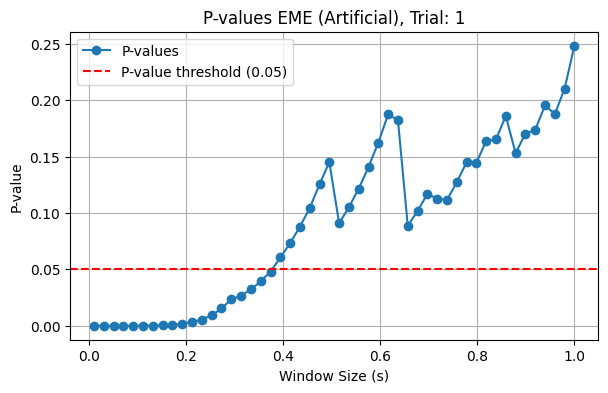

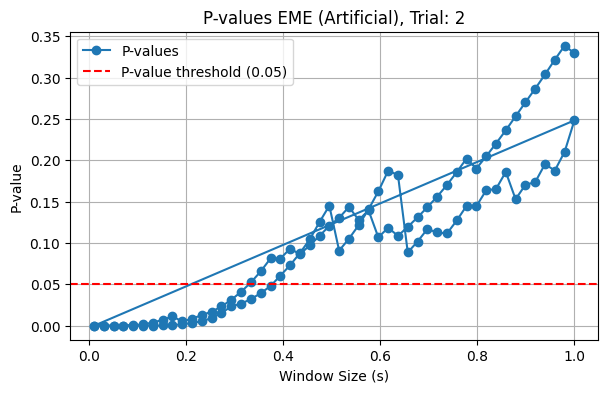

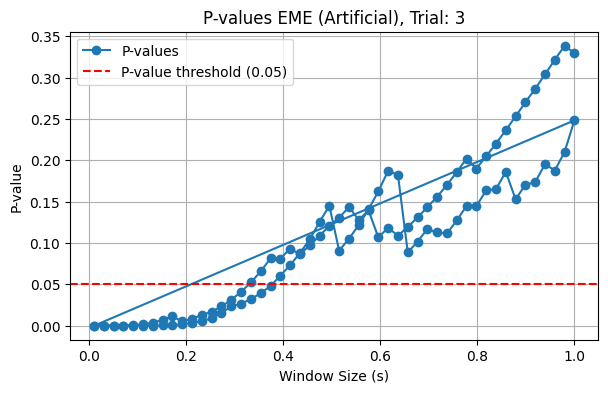

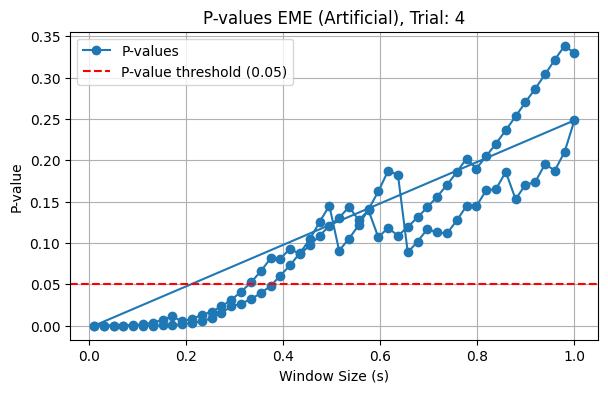

In [127]:
Optimal_win_size_Generated_EME.sliding_window_trial(trial_num=4)

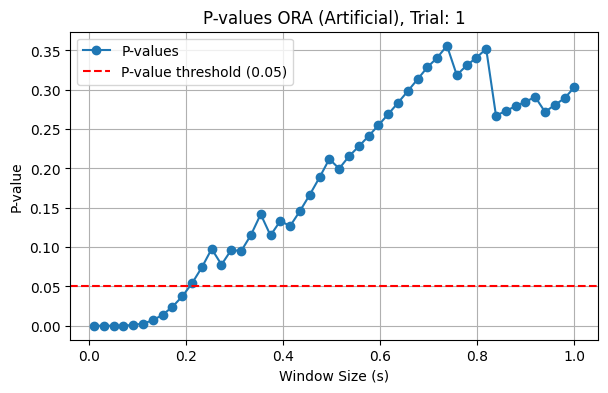

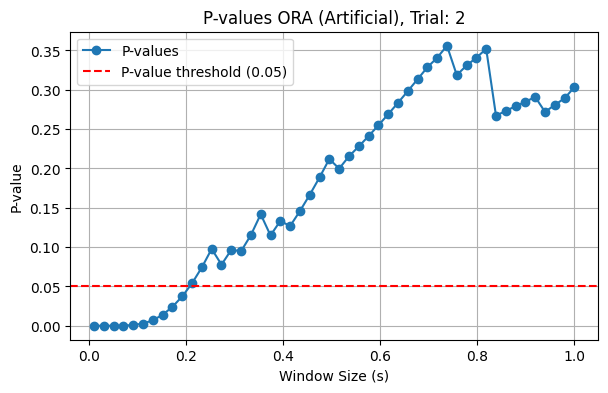

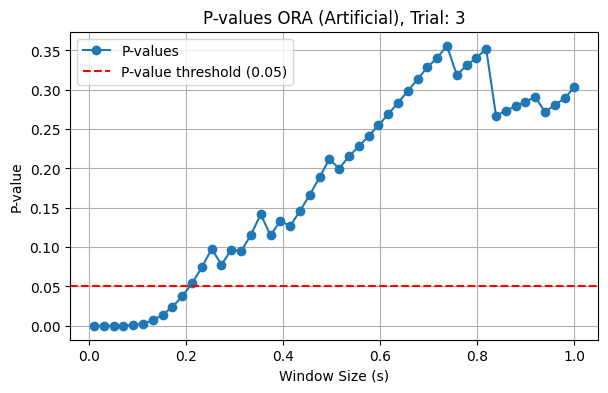

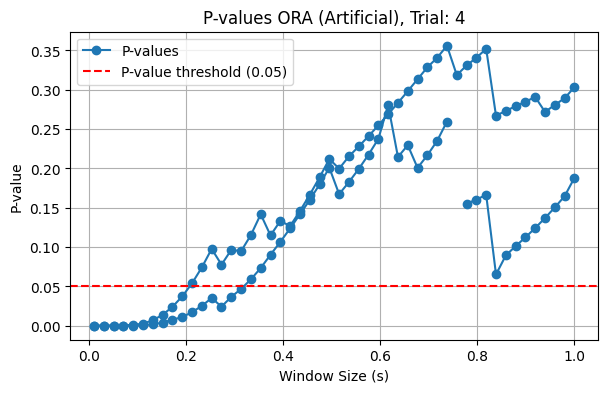

In [128]:
Optimal_win_size_Generated_ORA.sliding_window_trial(trial_num=4)

- 0.3 Seems like the ideal window size for EME
- 0.18 Seems like the ideal window size for ORA

## Display rate and correlations (artificial spikes)

In [129]:
Firing_Rate_Generated_EME = Fire_Rate_Estimation(spikes=art_neurons_EME.T, trials=Trials_EME[trial_index], dataset_name="EME (Artificial)")
Firing_Rate_Generated_ORA = Fire_Rate_Estimation(spikes=art_neurons_ORA.T, trials=Trials_ORA[trial_index_ORA], dataset_name="ORA (Artificial)")

In [130]:
rate_generated_EME = Firing_Rate_Generated_EME.Calculate_rate(window_size=.3)
rate_generated_ORA = Firing_Rate_Generated_ORA.Calculate_rate(window_size=.18)

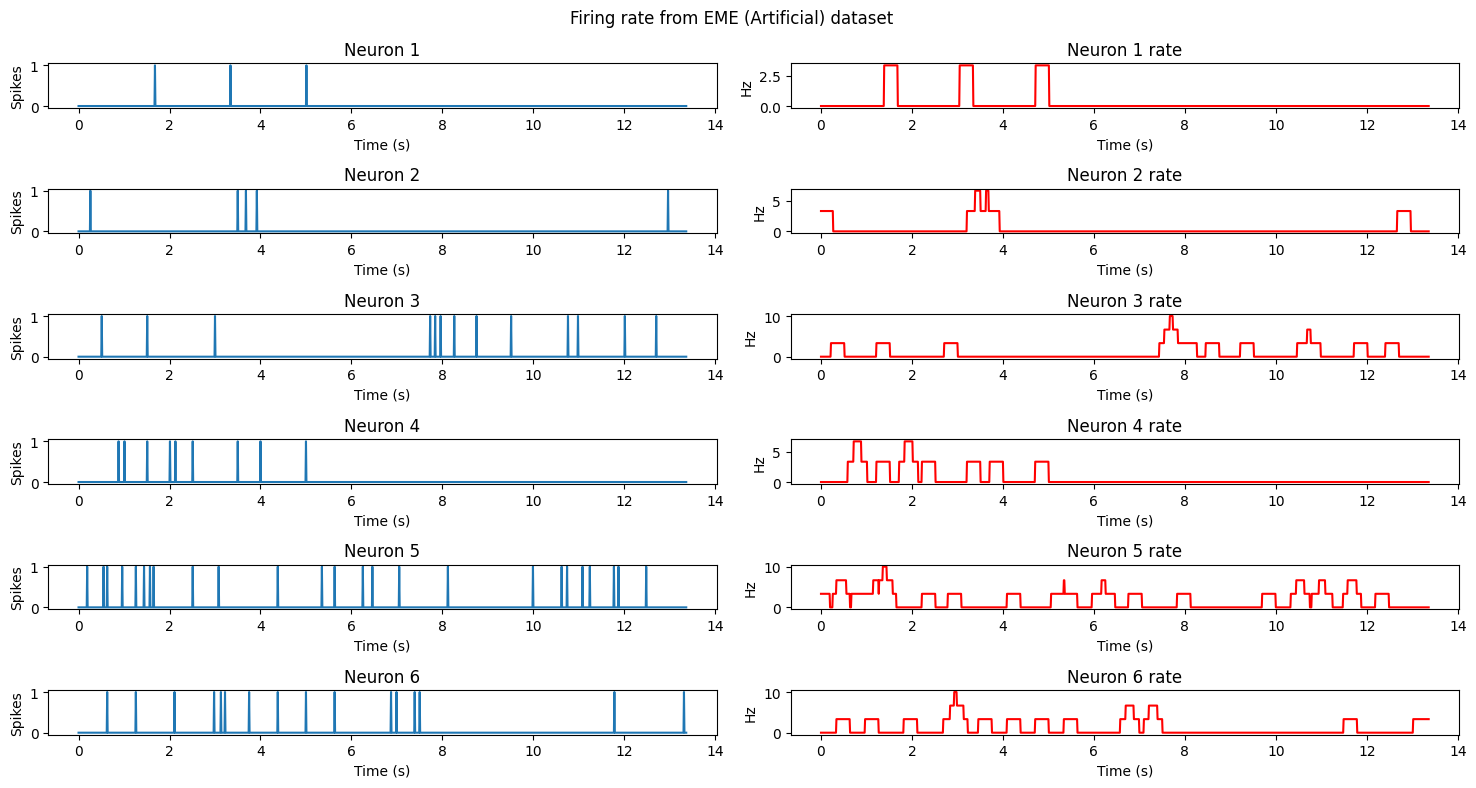

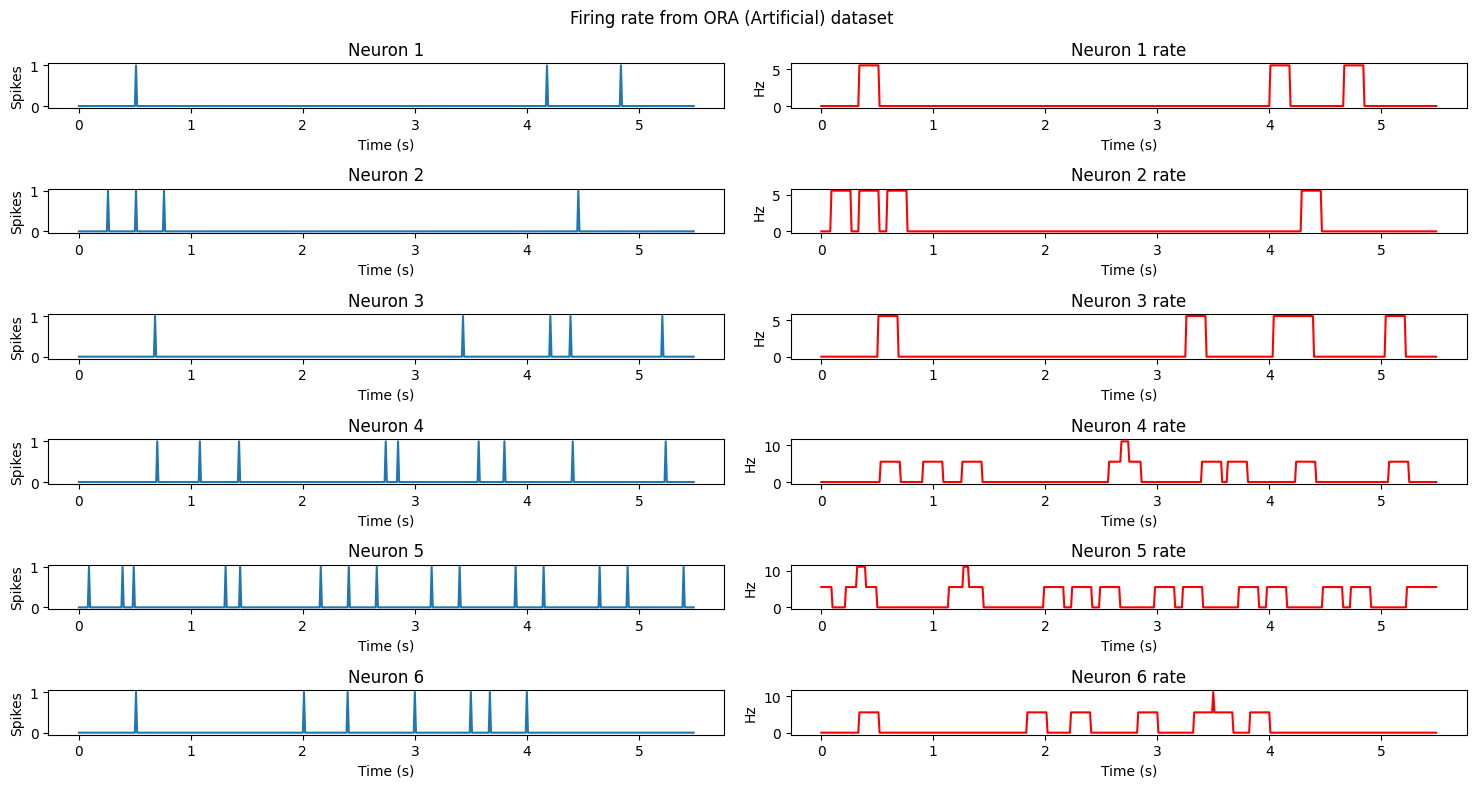

In [131]:
Firing_Rate_Generated_EME.display_aggregated_plot(rate_generated_EME)
Firing_Rate_Generated_ORA.display_aggregated_plot(rate_generated_ORA)

In [132]:
Firing_Rate_Generated_EME.Calculate_corrolation_coef(rate_generated_EME)

Corrolation rate and p-Value from EME (Artificial) Dataset


,Neuron,Correlation Coefficient,P-Value
0,Neuron 1,0.176520,8.057050e-11
1,Neuron 2,0.223748,1.243522e-16
2,Neuron 3,0.188780,3.427804e-12
3,Neuron 4,0.181770,2.141103e-11
4,Neuron 5,0.171539,2.731536e-10
5,Neuron 6,0.176845,7.430814e-11


In [133]:
Firing_Rate_Generated_ORA.Calculate_corrolation_coef(rate_generated_ORA)

Corrolation rate and p-Value from ORA (Artificial) Dataset


,Neuron,Correlation Coefficient,P-Value
0,Neuron 1,0.224446,1.039058e-07
1,Neuron 2,0.220537,1.743936e-07
2,Neuron 3,0.216543,2.931520e-07
3,Neuron 4,0.218077,2.404251e-07
4,Neuron 5,0.196753,3.330877e-06
5,Neuron 6,0.244373,6.387907e-09


## Model classification

In [134]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

@dataclass
class Classification_model():
    neurons_data: 'NDArray'
    dataset_name: str
    ground_truth: 'NDArray'
    dataset_type: str
    
    def build_model_fold(self, data_distribution: float, selected_model, fold_num: int):
        
        X, y = self.neurons_data, self.ground_truth
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_distribution, random_state=42)
        
        k = fold_num  # Number of folds
        kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Create KFold object

        accuracy_scores = []
        model_pred = []
        model_test = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = selected_model()  # Initialize the model
            model.fit(X_train, y_train) # Train the model

            y_pred = model.predict(X_val)  # Make predictions

            [model_pred.append(pred) for pred in y_pred]
            [model_test.append(test_val) for test_val in y_val]

        print("Selected model: ", selected_model().__str__(), f"- Dataset name: {self.dataset_name} -", self.dataset_type) 
        self._model_evaluation_metrics(y_test=model_test, predictions=model_pred)
        
    def build_model_leave_one_out(self, data_distribution: float, selected_model):
        X, y = self.neurons_data, self.ground_truth
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_distribution, random_state=42)
        
        loo = LeaveOneOut()
        results = []
        model_pred = []
        model_test = []
        
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            knn = selected_model()
            knn.fit(X_train, y_train)
            prediction = knn.predict(X_test)
            
            [model_pred.append(pred) for pred in prediction]
            [model_test.append(test_val) for test_val in y_test]
            
           
        print("Selected model: ", selected_model().__str__(), f"- Dataset name: {self.dataset_name} -", self.dataset_type) 
        self._model_evaluation_metrics(y_test=model_test, predictions=model_pred)
        
    def compare_models(self, data_distribution: float):
        X, y = self.neurons_data, self.ground_truth
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=data_distribution, random_state=42)
        
        # ML algorithms
        models = []
        models.append(('Linear Regression', LogisticRegression(solver = 'liblinear', multi_class= 'ovr')))
        models.append(("Linear Discriminant Analysis", LinearDiscriminantAnalysis()))
        models.append(("Decision Tree Classifier", DecisionTreeClassifier()))
        models.append(("K-Neighbors Classifier", KNeighborsClassifier()))
        models.append(("Gaussian NB", GaussianNB()))
        models.append(("SVM", SVC()))
        
        results = []
        names = []
        for name, model in models:
            cv = KFold(n_splits=20, random_state=None)
            scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=cv)
            names.append(name)
            results.append(scores)
            print("%s - Model accuracy: %.2f - Model error rate: (%.2f)" % (name, scores.mean(), scores.std()))
            
        # compare algorithm
        fig = plt.figure(figsize=(15, 8))
        fig.suptitle(f"Algorithm Comparison {self.dataset_name} - {self.dataset_type}")
        ax = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        ax.set_ylabel("Accuracy score")
        plt.show()
            
    def _model_evaluation_metrics(self, y_test, predictions):
        conf_matrix = confusion_matrix(y_test, predictions)
        self._show_confusion_matric(conf_matrix)
        #Evaluate Prediction
        print('Accuracy Score:', accuracy_score(y_test, predictions), "\n")

        # print('Confusion Matrix')
        # print(confusion_matrix(y_test, predictions), "\n")

        print('Classification Report')
        print(classification_report(y_test, predictions, zero_division=1))
        
    def _show_confusion_matric(self, cnn_matrix):
        labels = np.unique(self.ground_truth)
        plt.figure(figsize=(6,5))
        sns.heatmap(cnn_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix {self.dataset_name} - ({self.dataset_type})')
        plt.show()

In [135]:
selected_trials = 4
trial_index_EME = (Trials_EME <= selected_trials) # First 4 trials
trial_index_ORA = (Trials_ORA <= selected_trials) # First 4 trials

In [136]:
print("Ground truth classes number for first 4 trials (EME)")
for i in np.unique(ground_tr_EME[trial_index_EME]):
    print("Class", int(i))
    
print("Ground truth classes number for first 4 trials (ORA)")
for i in np.unique(ground_tr_ORA[trial_index_ORA]):
    print("Class", int(i))

Ground truth classes number for first 4 trials (EME)
Class 1
Class 3
Ground truth classes number for first 4 trials (ORA)
Class 3
Class 4


### Model classification of real neurons

In [137]:
CLASSIFICATION_EME = Classification_model(neurons_data=rate_EME[trial_index_EME, :-1], dataset_name="EME", ground_truth=ground_tr_EME[trial_index_EME], dataset_type="Real neurons")
CLASSIFICATION_ORA = Classification_model(neurons_data=rate_ORA[trial_index_ORA, :-1], dataset_name="ORA", ground_truth=ground_tr_ORA[trial_index_ORA], dataset_type="Real neurons")

Linear Regression - Model accuracy: 0.75 - Model error rate: (0.06)
Linear Discriminant Analysis - Model accuracy: 0.74 - Model error rate: (0.06)
Decision Tree Classifier - Model accuracy: 0.76 - Model error rate: (0.04)
K-Neighbors Classifier - Model accuracy: 0.77 - Model error rate: (0.05)
Gaussian NB - Model accuracy: 0.75 - Model error rate: (0.06)
SVM - Model accuracy: 0.77 - Model error rate: (0.04)


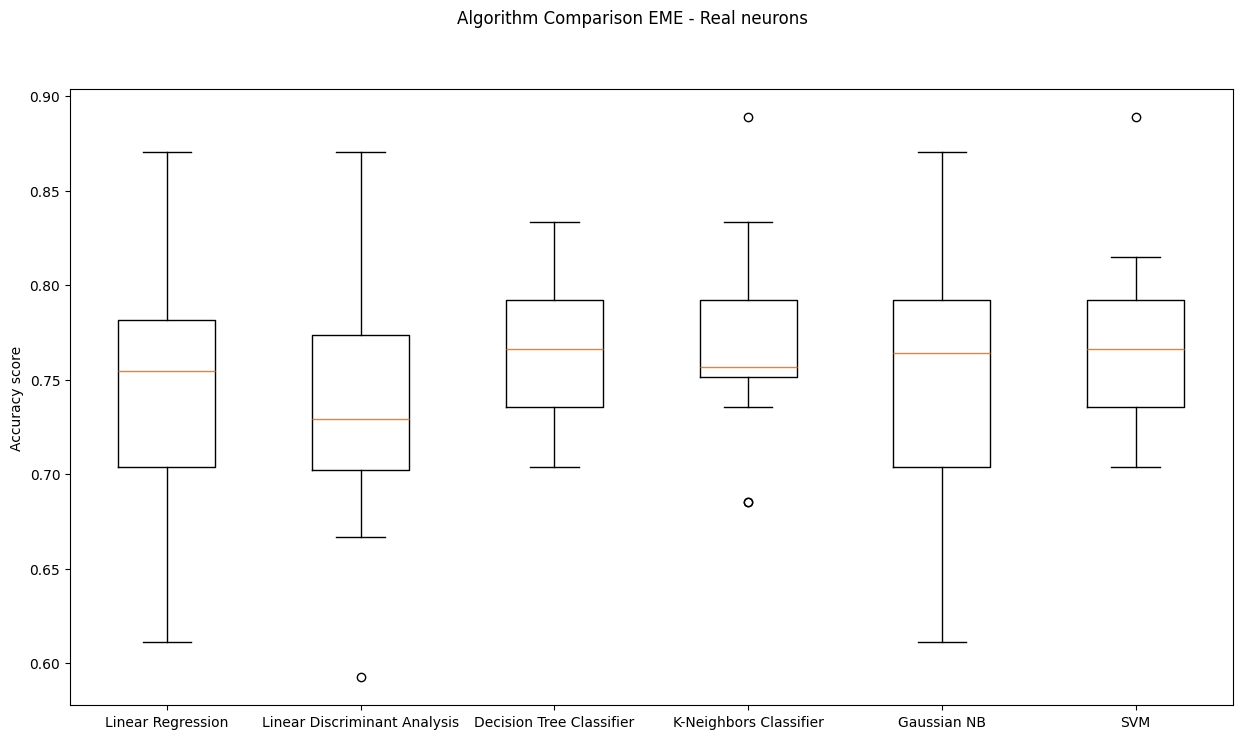

In [138]:
CLASSIFICATION_EME.compare_models(data_distribution=.2)

Linear Regression - Model accuracy: 0.75 - Model error rate: (0.10)
Linear Discriminant Analysis - Model accuracy: 0.75 - Model error rate: (0.10)
Decision Tree Classifier - Model accuracy: 0.78 - Model error rate: (0.10)
K-Neighbors Classifier - Model accuracy: 0.76 - Model error rate: (0.10)
Gaussian NB - Model accuracy: 0.73 - Model error rate: (0.11)
SVM - Model accuracy: 0.78 - Model error rate: (0.09)


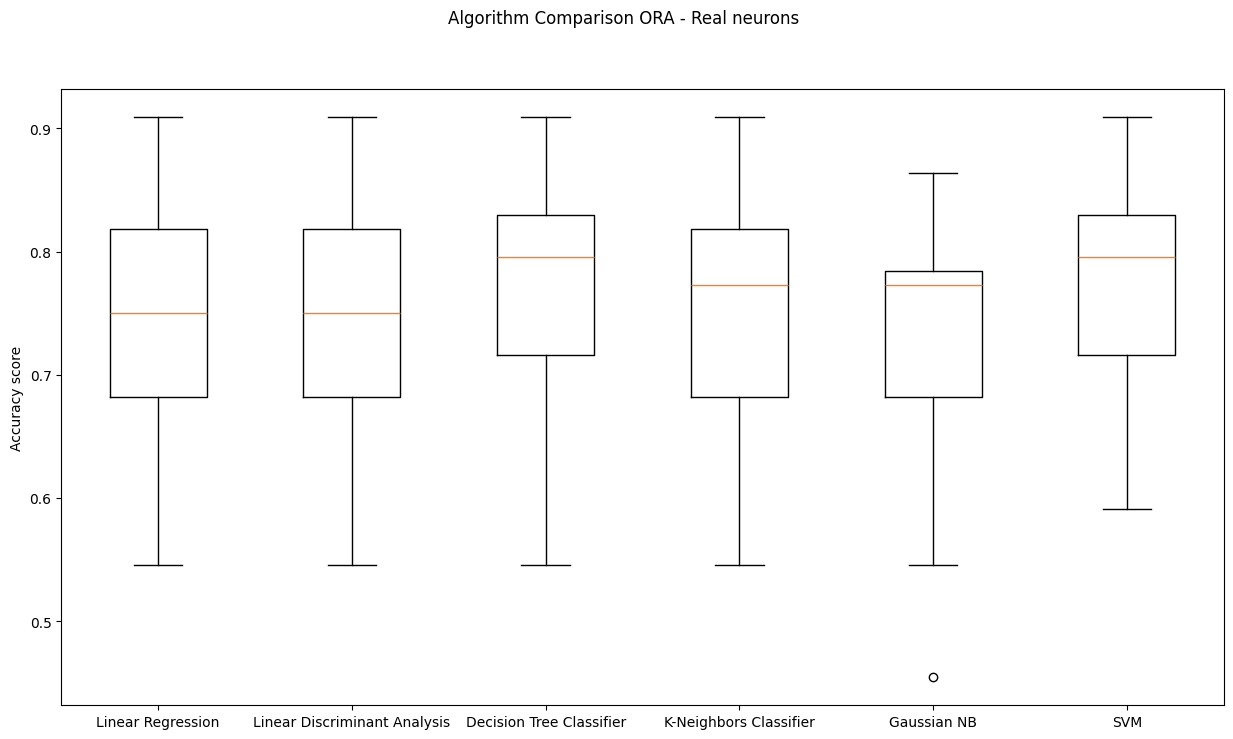

In [139]:
CLASSIFICATION_ORA.compare_models(data_distribution=.2)

- Decision Tree looks like the best performing model

Selected model:  DecisionTreeClassifier() - Dataset name: EME - Real neurons


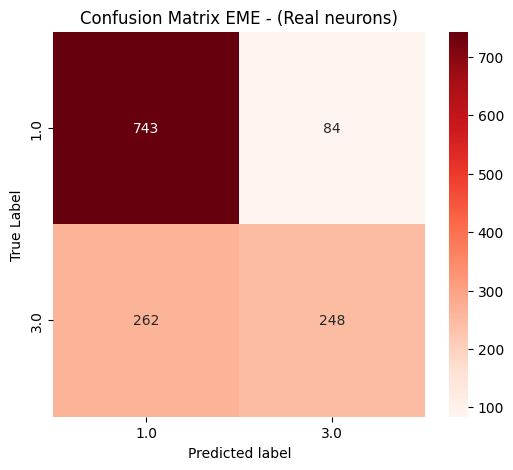

Accuracy Score: 0.7412116679132386 

Classification Report
              precision    recall  f1-score   support

         1.0       0.74      0.90      0.81       827
         3.0       0.75      0.49      0.59       510

    accuracy                           0.74      1337
   macro avg       0.74      0.69      0.70      1337
weighted avg       0.74      0.74      0.73      1337



In [140]:
CLASSIFICATION_EME.build_model_fold(data_distribution=.2, selected_model=DecisionTreeClassifier, fold_num=15)

Selected model:  DecisionTreeClassifier() - Dataset name: ORA - Real neurons


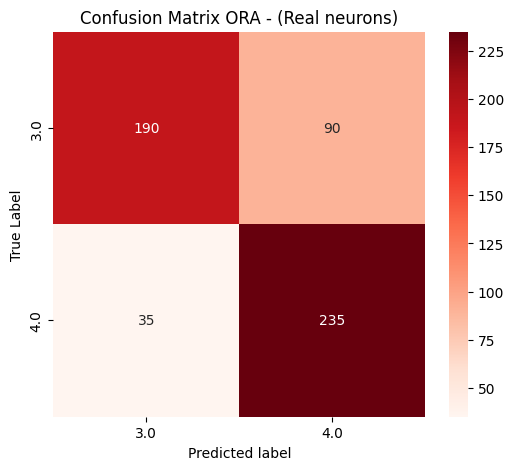

Accuracy Score: 0.7727272727272727 

Classification Report
              precision    recall  f1-score   support

         3.0       0.84      0.68      0.75       280
         4.0       0.72      0.87      0.79       270

    accuracy                           0.77       550
   macro avg       0.78      0.77      0.77       550
weighted avg       0.78      0.77      0.77       550



In [141]:
CLASSIFICATION_ORA.build_model_fold(data_distribution=.2, selected_model=DecisionTreeClassifier, fold_num=15)

### Model classification for artificial neurons

In [142]:
CLASSIFICATION_Generated_EME = Classification_model(neurons_data=art_neurons_EME.T, dataset_name="EME", ground_truth=ground_tr_EME[trial_index_EME], dataset_type="Artificial neurons")
CLASSIFICATION_Generated_ORA = Classification_model(neurons_data=art_neurons_ORA.T, dataset_name="ORA", ground_truth=ground_tr_ORA[trial_index_ORA], dataset_type="Artificial neurons")

Linear Regression - Model accuracy: 0.63 - Model error rate: (0.06)
Linear Discriminant Analysis - Model accuracy: 0.63 - Model error rate: (0.06)
Decision Tree Classifier - Model accuracy: 0.63 - Model error rate: (0.06)
K-Neighbors Classifier - Model accuracy: 0.62 - Model error rate: (0.06)
Gaussian NB - Model accuracy: 0.62 - Model error rate: (0.06)
SVM - Model accuracy: 0.62 - Model error rate: (0.06)


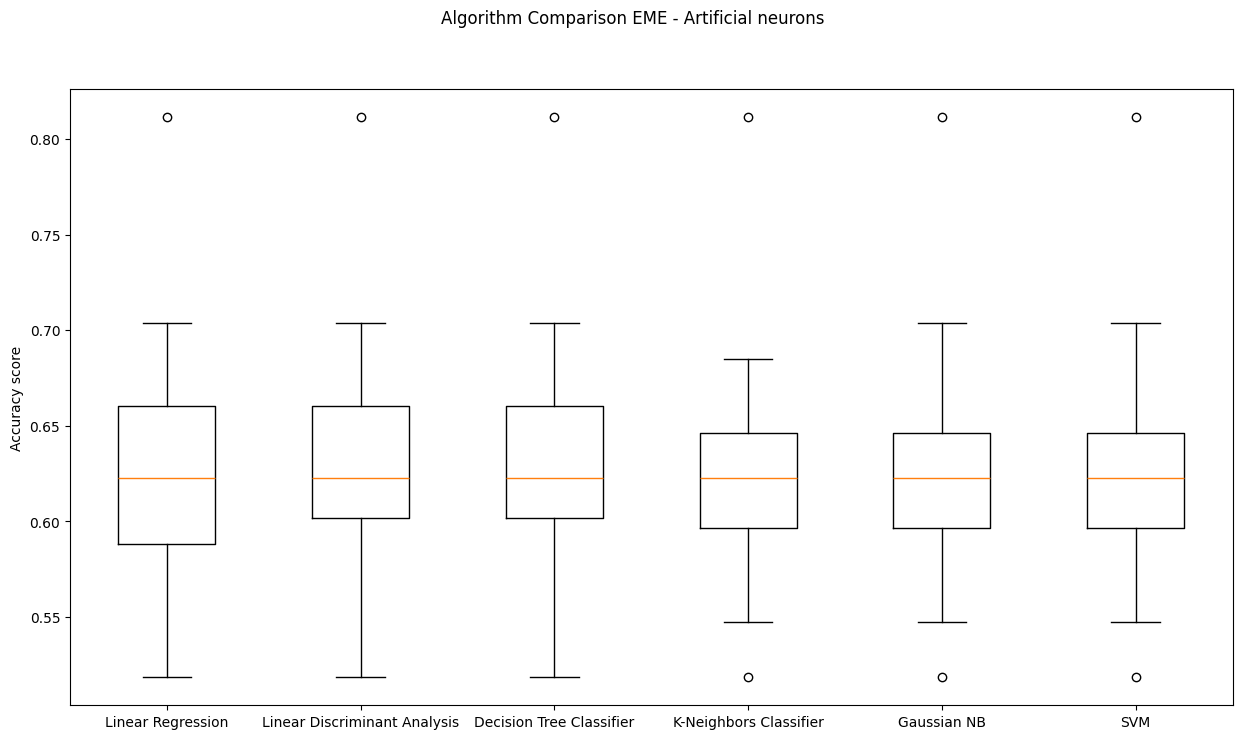

In [143]:
CLASSIFICATION_Generated_EME.compare_models(data_distribution=.2)

Linear Regression - Model accuracy: 0.51 - Model error rate: (0.12)
Linear Discriminant Analysis - Model accuracy: 0.51 - Model error rate: (0.12)
Decision Tree Classifier - Model accuracy: 0.51 - Model error rate: (0.12)
K-Neighbors Classifier - Model accuracy: 0.50 - Model error rate: (0.10)
Gaussian NB - Model accuracy: 0.49 - Model error rate: (0.11)
SVM - Model accuracy: 0.51 - Model error rate: (0.12)


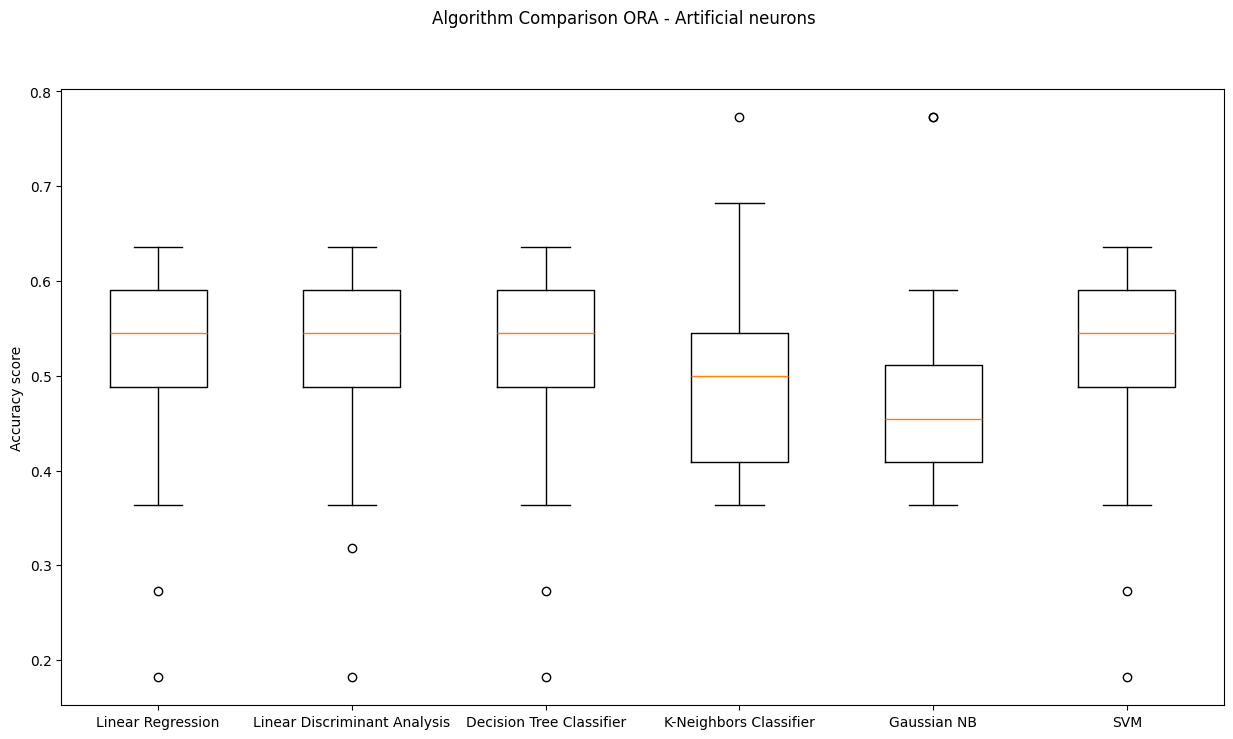

In [144]:
CLASSIFICATION_Generated_ORA.compare_models(data_distribution=.2)

Selected model:  DecisionTreeClassifier() - Dataset name: EME - Artificial neurons


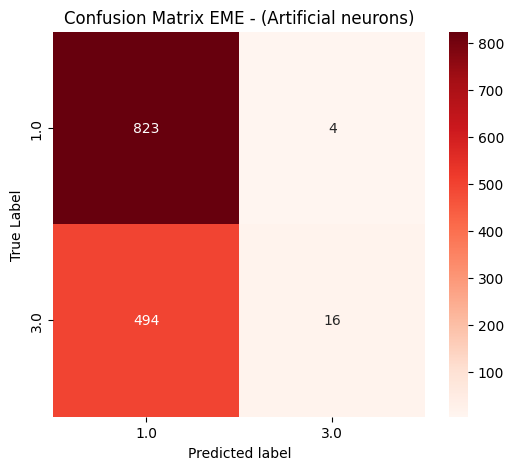

Accuracy Score: 0.6275243081525804 

Classification Report
              precision    recall  f1-score   support

         1.0       0.62      1.00      0.77       827
         3.0       0.80      0.03      0.06       510

    accuracy                           0.63      1337
   macro avg       0.71      0.51      0.41      1337
weighted avg       0.69      0.63      0.50      1337



In [145]:
CLASSIFICATION_Generated_EME.build_model_fold(data_distribution=.2, selected_model=DecisionTreeClassifier, fold_num=15)

Selected model:  GaussianNB() - Dataset name: ORA - Artificial neurons


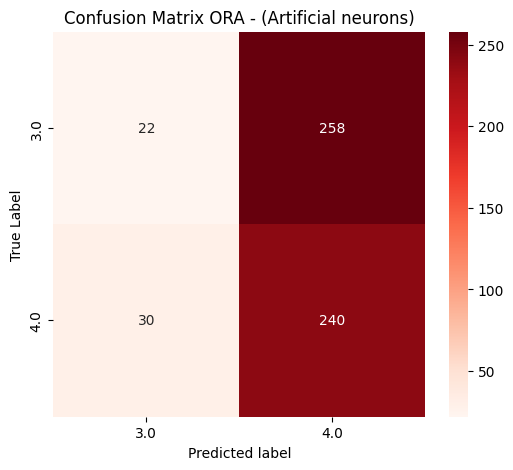

Accuracy Score: 0.4763636363636364 

Classification Report
              precision    recall  f1-score   support

         3.0       0.42      0.08      0.13       280
         4.0       0.48      0.89      0.62       270

    accuracy                           0.48       550
   macro avg       0.45      0.48      0.38       550
weighted avg       0.45      0.48      0.37       550



In [146]:
CLASSIFICATION_Generated_ORA.build_model_fold(data_distribution=.2, selected_model=GaussianNB, fold_num=15)